##Environment Setup

In [ ]:
# # Install Geopandas
!pip install git+git://github.com/geopandas/geopandas.git --quiet


     |████████████████████████████████| 14.8MB 336kB/s 
     |████████████████████████████████| 6.5MB 55.4MB/s 


In [ ]:
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import gzip
import csv

import geopandas as gpd 
import json
from pandas.io.json import json_normalize
import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
import scipy
import math
import statsmodels.api as sm
from statsmodels.graphics.factorplots import interaction_plot




/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_file='drive/My Drive/FNCE 237 Final Project/listings.csv.gz'
import io
uncleaned_data = pd.read_csv('drive/My Drive/FNCE 237 Final Project/listings.csv.gz', compression='gzip',  error_bad_lines=False)
pd.set_option('display.max_columns', len(uncleaned_data.columns)) # To view all columns
pd.set_option('display.max_rows', 100)



##Data Cleaning

In [ ]:
#remove unnecessary columns,columns with several missing values, columns that are likely to be very correlated with others
not_needed= ['listing_url', 'scrape_id', 'last_scraped', 'name', 'description', 'neighborhood_overview', 'picture_url', 'host_id', 'host_url', 'host_name', 'host_location', 'host_about', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_verifications', 'calendar_last_scraped','host_acceptance_rate', 'neighbourhood_group_cleansed', 
          'license', 'host_total_listings_count', 'calculated_host_listings_count', 'host_response_time','calculated_host_listings_count_entire_homes', 'bathrooms', 'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms', 'calendar_updated', 'neighbourhood', 'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'has_availability', 'host_has_profile_pic', 'reviews_per_month', 'number_of_reviews_l30d', 'number_of_reviews_ltm','availability_30', 'availability_60', 'availability_90']
cleaner_data= uncleaned_data.drop(not_needed, axis=1)
cleaner_data.head(3)

,id,host_since,host_response_rate,host_is_superhost,host_listings_count,host_identity_verified,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,availability_365,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable
0,1419,2008-08-08,NaN,f,1.0,t,Little Portugal,43.64617,-79.42451,Entire house,Entire home/apt,10,3 baths,5.0,7.0,"[""Shampoo"", ""TV"", ""Dryer"", ""Indoor fireplace"",...",$469.00,4,730,0,7,2015-07-19,2017-12-04,100.0,10.0,10.0,10.0,10.0,10.0,10.0,f
1,8077,2009-06-22,NaN,f,2.0,f,Waterfront Communities-The Island,43.64105,-79.37628,Private room in apartment,Private room,2,1.5 baths,1.0,1.0,"[""Shampoo"", ""TV"", ""Pool"", ""Gym"", ""Free parking...",$99.00,180,365,365,169,2009-08-20,2013-08-27,97.0,10.0,10.0,10.0,10.0,10.0,10.0,t
2,12604,2009-10-25,NaN,f,1.0,t,Annex,43.66724,-79.41598,Private room in house,Private room,1,1.5 baths,1.0,1.0,"[""Indoor fireplace"", ""Wifi""]",$66.00,1,10,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f


In [ ]:
#percentage of null values in each field
#0 means there are no NA values (this is good)
cleaner_data.isna().sum()/len(cleaner_data)

id                             0.000000
host_since                     0.000207
host_response_rate             0.389236
host_is_superhost              0.000207
host_listings_count            0.000207
host_identity_verified         0.000207
neighbourhood_cleansed         0.000000
latitude                       0.000000
longitude                      0.000000
property_type                  0.000000
room_type                      0.000000
accommodates                   0.000000
bathrooms_text                 0.000672
bedrooms                       0.073877
beds                           0.010133
amenities                      0.000000
price                          0.000000
minimum_nights                 0.000000
maximum_nights                 0.000000
availability_365               0.000000
number_of_reviews              0.000000
first_review                   0.210154
last_review                    0.210154
review_scores_rating           0.224009
review_scores_accuracy         0.225766


In [ ]:
# host_response_rate
cleaner_data.host_response_rate = cleaner_data.host_response_rate.str[:-1].astype('float64')
cleaner_data.host_response_rate.replace('nan', 'unknown', inplace=True)

#bath_num
cleaner_data['bath_num']=cleaner_data.bathrooms_text.str.extract('(\d*(\.\d)?)').iloc[:,0]   
cleaner_data.drop('bathrooms_text', axis=1, inplace=True)
cleaner_data['bath_num']=cleaner_data.bath_num.replace('', np.nan).astype("float")

#removing $ from price
cleaner_data['new_price']=cleaner_data.price.apply(lambda x: x.strip('$'))
cleaner_data['new_price'] = cleaner_data['new_price'].str.replace(',', '')
cleaner_data.new_price = cleaner_data.new_price.astype('float64')

#host_since
cleaner_data.host_since = pd.to_datetime(cleaner_data.host_since) 

#converting times of reviews to datetimes
cleaner_data.first_review = pd.to_datetime(cleaner_data.first_review)
cleaner_data.last_review = pd.to_datetime(cleaner_data.last_review)

In [ ]:
#host_response_rate variable
print("Mean host response rate:", round(cleaner_data['host_response_rate'].mean(),0))
print("Median host response rate:", cleaner_data['host_response_rate'].median())

Mean host response rate: 90.0
Median host response rate: 100.0


In [ ]:
# separate host_response_rate into categories
cleaner_data.host_response_rate = pd.cut(cleaner_data.host_response_rate, 
                               bins=[0, 50, 90, 99, 100], 
                               labels=['0-49%', '50-89%', '90-99%', '100%'], 
                               include_lowest=True)

cleaner_data.host_response_rate = cleaner_data.host_response_rate.astype('str')
cleaner_data.host_response_rate.replace('nan', 'missing', inplace=True)
cleaner_data.host_response_rate.value_counts()


100%       7613
missing    7529
50-89%     1750
90-99%     1491
0-49%       960
Name: host_response_rate, dtype: int64

In [ ]:
#removing rows were there in no data on the host
len(cleaner_data[cleaner_data.loc[ :,['host_since', 'host_is_superhost', 'host_listings_count', 
                  'host_identity_verified'] ].isna().sum(axis=1) == 4])

cleaner_data.dropna(subset=['host_since'], inplace=True)
#cleaner_data.head()

In [ ]:
#most airbnb listings have 1 bathroom which is also the median so we will replace missing rows with this
for column in ['bedrooms', 'beds']:
    cleaner_data[column].fillna(cleaner_data[column].median())

In [ ]:
# Calculating the number of days the host has been on airbnb
cleaner_data['host_number_days'] = (pd.to_datetime('2020-09-29') - cleaner_data.host_since).astype('timedelta64[D]')

# Replacing null values with the median
cleaner_data.host_number_days.fillna(cleaner_data.host_number_days.median(), inplace=True)

In [ ]:
# Calculating the number of days between the first review and the date the data was scraped
cleaner_data['time_since_first_review'] = (pd.to_datetime("2020-09-29") - cleaner_data.first_review)
cleaner_data['time_since_last_review'] = (pd.to_datetime("2020-09-29") - cleaner_data.last_review)


In [ ]:
cleaner_data['property_type_real']=cleaner_data['property_type']

In [ ]:
#changing property type to fit into generic categories
cleaner_data.property_type.replace({
    'Entire townhouse': 'House',
    'Entire place':'Apartment',
    'Entire condominium': 'Apartment',
    'Entire apartment ': 'Apartment',    
    'Serviced apartment': 'Apartment',
    'Entire serviced apartment':'Apartment',
    'Entire home/apt': 'Apartment',
    'Entire apartment': 'Apartment',
    'Private room in apartment':'Apartment',
    'Private room':'House',
    'Shared room':'House',
    'Private room in serviced apartment':'Apartment',
    'Room in serviced apartment':'Apartment',
    'Private room in house':'House',
    'Entire house':'House',
    'Entire room in cottage': 'House',
    'Entire guest suite': 'House',
    'Shared room in villa':'House',
    'Private room in villa':'House',
    'Entire villa ':'House',
    'Shared room in apartment': 'Apartment',
    'Shared room in house':'House',
    'Shared room in condominium':'Apartment',
    'Private room in condominium':'Apartment',
    'Shared room in townhouse':'House',
    'Private room in townhouse':'House',
    'Shared room in bungalow':'House',
    'Private room in bungalow':'House',
    'Entire bungalow':'House',
    'Loft': 'Apartment', 
    'Entire loft': 'Apartment', 
    'Shared room in guest suite':'House',   
    'Private room in guest suite':'House',
    'Private room in loft': 'Apartment',
    'Shared room in loft': 'Apartment',
    'Entire guesthouse' : 'House',
    'Private room in guesthouse': 'House',
    'Room in boutique hotel':'Hotel',
    'Room in hotel':'Hotel',
    'Room in aparthotel':'Hotel',
    'Private room in bed and breakfast': 'Hotel',
    'Room in bed and breakfast': 'Hotel',
    'Entire floor' : 'House',
    'Shared room in guesthouse':'House',
    'Entire villa':'House',
    'Shared room in bed and breakfast':'Hotel'
    }, inplace=True)

# Replacing other categories with 'other type'
cleaner_data.loc[~cleaner_data.property_type.isin(['House', 'Apartment', 'Hotel']), 'property_type'] = 'Other Type'

In [ ]:
#changing room type to fit into generic categories
cleaner_data.room_type.replace({
    'Hotel room': 'Private room'}, inplace=True)

In [ ]:
cleaner_data.amenities[:].values

array(['["Shampoo", "TV", "Dryer", "Indoor fireplace", "Fire extinguisher", "Kitchen", "Wifi", "Air conditioning", "Heating", "Washer", "Smoke alarm", "First aid kit", "Essentials"]',
       '["Shampoo", "TV", "Pool", "Gym", "Free parking on premises", "Wifi", "Air conditioning", "Heating", "Elevator", "Smoke alarm", "Cable TV"]',
       '["Indoor fireplace", "Wifi"]', ...,
       '["Shampoo", "Dryer", "Kitchen", "Hangers", "Wifi", "Heating", "Washer", "Hair dryer", "Essentials", "Laptop-friendly workspace"]',
       '["Carbon monoxide alarm", "Shampoo", "TV", "Dryer", "Private entrance", "Kitchen", "Hangers", "Wifi", "Heating", "Washer", "Smoke alarm", "Essentials", "Laptop-friendly workspace"]',
       '["Carbon monoxide alarm", "Private entrance", "Kitchen", "Paid parking on premises", "Air conditioning", "Essentials", "Smoke alarm", "Dishwasher", "Stove", "Dryer", "Washer", "Shampoo", "Patio or balcony", "Oven", "Host greets you", "Long term stays allowed", "Gym", "Cleaning before 

In [ ]:
#assign amenities into categories and add columns for each category
cleaner_data.loc[cleaner_data['amenities'].str.contains('Air conditioning|Central air conditioning'), 'air_conditioning'] = 1
cleaner_data.loc[cleaner_data['amenities'].str.contains('Amazon Echo|Apple TV|Game console|Netflix|Projector and screen|Smart TV'), 'high_end_electronics'] = 1
cleaner_data.loc[cleaner_data['amenities'].str.contains('BBQ grill|Fire pit|Propane barbeque'), 'bbq'] = 1
cleaner_data.loc[cleaner_data['amenities'].str.contains('Balcony|Patio|Patio or balcony'), 'balcony_or_patio'] = 1
cleaner_data.loc[cleaner_data['amenities'].str.contains('Beach view|Beachfront|Lake access|Mountain view|Ski-in/Ski-out|Waterfront'), 'nature_and_views'] = 1
cleaner_data.loc[cleaner_data['amenities'].str.contains('Bed linens'), 'bed_linen'] = 1
cleaner_data.loc[cleaner_data['amenities'].str.contains('Breakfast'), 'breakfast'] = 1
cleaner_data.loc[cleaner_data['amenities'].str.contains('TV|Cable TV'), 'tv'] = 1
cleaner_data.loc[cleaner_data['amenities'].str.contains('Coffee maker|Espresso machine'), 'coffee_machine'] = 1
cleaner_data.loc[cleaner_data['amenities'].str.contains('Cooking basics|Kitchen|Microwave|Stove|Oven|Refrigerator'), 'cooking_basics'] = 1
cleaner_data.loc[cleaner_data['amenities'].str.contains('Dishwasher|Dryer|Washer'), 'major_appliances'] = 1
cleaner_data.loc[cleaner_data['amenities'].str.contains('Elevator'), 'elevator'] = 1
cleaner_data.loc[cleaner_data['amenities'].str.contains('Exercise equipment|Gym|gym'), 'gym'] = 1
cleaner_data.loc[cleaner_data['amenities'].str.contains('Family/kid friendly|Children|children'), 'child_friendly'] = 1
cleaner_data.loc[cleaner_data['amenities'].str.contains('parking|Free parking on premises|Paid parking|Paid parking off premises'), 'parking'] = 1
cleaner_data.loc[cleaner_data['amenities'].str.contains('Garden|Outdoor|Sun loungers|Terrace'), 'outdoor_space'] = 1
cleaner_data.loc[cleaner_data['amenities'].str.contains('Host greets you'), 'host_greeting'] = 1
cleaner_data.loc[cleaner_data['amenities'].str.contains('Hot tub|Jetted tub|hot tub|Sauna|Pool|pool'), 'hot_tub_sauna_or_pool'] = 1
cleaner_data.loc[cleaner_data['amenities'].str.contains('Internet|Pocket wifi|Wifi'), 'internet'] = 1
cleaner_data.loc[cleaner_data['amenities'].str.contains('Long term stays allowed'), 'long_term_stays'] = 1
cleaner_data.loc[cleaner_data['amenities'].str.contains('Pets|pet|Cat(s)|Dog(s)'), 'pets_allowed'] = 1
cleaner_data.loc[cleaner_data['amenities'].str.contains('Private entrance'), 'private_entrance'] = 1
cleaner_data.loc[cleaner_data['amenities'].str.contains('Self check-in'), 'self_check_in'] = 1
cleaner_data.loc[cleaner_data['amenities'].str.contains('Smoking allowed'), 'smoking_allowed'] = 1
cleaner_data.loc[cleaner_data['amenities'].str.contains('Step-free access|Wheelchair|Accessible'), 'accessible'] = 1
cleaner_data.loc[cleaner_data['amenities'].str.contains('Suitable for events'), 'event_suitable'] = 1
cleaner_data.loc[cleaner_data['amenities'].str.contains('Fire extinguisher|Smoke alarm|Carbon monoxide alarm'), 'Fire_Safety'] = 1
cleaner_data.loc[cleaner_data['amenities'].str.contains('Shampoo|Essentials|Hair dryer|Shower gel'), 'essentials'] = 1
cleaner_data.loc[cleaner_data['amenities'].str.contains('Laptop-friendly workspace'), 'computer_workspace'] = 1
cleaner_data.loc[cleaner_data['amenities'].str.contains('Fireplace|Indoor fireplace'), 'fireplace'] = 1


# Replacing nulls with zeros for new columns
cols_to_replace_nulls = cleaner_data.iloc[:,38:].columns
cleaner_data[cols_to_replace_nulls] = cleaner_data[cols_to_replace_nulls].fillna(0)

cleaner_data.head(4)

/usr/local/lib/python3.6/dist-packages/pandas/core/strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


,id,host_since,host_response_rate,host_is_superhost,host_listings_count,host_identity_verified,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,availability_365,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,bath_num,new_price,host_number_days,time_since_first_review,time_since_last_review,property_type_real,air_conditioning,high_end_electronics,bbq,balcony_or_patio,nature_and_views,bed_linen,breakfast,tv,coffee_machine,cooking_basics,major_appliances,elevator,gym,child_friendly,parking,outdoor_space,host_greeting,hot_tub_sauna_or_pool,internet,long_term_stays,pets_allowed,private_entrance,self_check_in,smoking_allowed,accessible,event_suitable,Fire_Safety,essentials,computer_workspace,fireplace
0,1419,2008-08-08,missing,f,1.0,t,Little Portugal,43.64617,-79.42451,House,Entire home/apt,10,5.0,7.0,"[""Shampoo"", ""TV"", ""Dryer"", ""Indoor fireplace"",...",$469.00,4,730,0,7,2015-07-19,2017-12-04,100.0,10.0,10.0,10.0,10.0,10.0,10.0,f,3.0,469.0,4435.0,1899 days,1030 days,Entire house,1.0,NaN,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0
1,8077,2009-06-22,missing,f,2.0,f,Waterfront Communities-The Island,43.64105,-79.37628,Apartment,Private room,2,1.0,1.0,"[""Shampoo"", ""TV"", ""Pool"", ""Gym"", ""Free parking...",$99.00,180,365,365,169,2009-08-20,2013-08-27,97.0,10.0,10.0,10.0,10.0,10.0,10.0,t,1.5,99.0,4117.0,4058 days,2590 days,Private room in apartment,1.0,NaN,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
2,12604,2009-10-25,missing,f,1.0,t,Annex,43.66724,-79.41598,House,Private room,1,1.0,1.0,"[""Indoor fireplace"", ""Wifi""]",$66.00,1,10,0,0,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,1.5,66.0,3992.0,NaT,NaT,Private room in house,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,23691,2010-03-15,missing,f,2.0,t,Briar Hill-Belgravia,43.69602,-79.45468,House,Private room,3,1.0,1.0,"[""Carbon monoxide alarm"", ""Private entrance"", ...",$70.00,1,28,209,217,2010-05-31,2019-12-22,95.0,10.0,10.0,10.0,10.0,9.0,10.0,t,1.0,70.0,3851.0,3774 days,282 days,Private room in house,1.0,NaN,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0


In [ ]:
# Replacing nulls with zeros for new columns
cols_to_replace_nulls = cleaner_data.loc[:,'air_conditioning':].columns
cleaner_data[cols_to_replace_nulls] = cleaner_data[cols_to_replace_nulls].fillna(0)

# Produces a list of amenity features where one category (true or false) contains fewer than 10% of listings
infrequent_amenities = []
for col in cleaner_data.loc[:,'air_conditioning':].columns:
    if cleaner_data[col].sum() < len(cleaner_data)/20:
        infrequent_amenities.append(col)
print(infrequent_amenities)

# Dropping infrequent amenity features
cleaner_data.drop(infrequent_amenities, axis=1, inplace=True)


['high_end_electronics', 'child_friendly', 'pets_allowed', 'self_check_in', 'smoking_allowed', 'accessible', 'event_suitable']


In [ ]:
#making a copy of cleaner_data where we'll put variables with missing values as categorical
cleaned = cleaner_data.copy()

In [ ]:
#make variables with missing columns categorical
def make_categorical(c, bins, labels, na_label='no reviews'):
   
    cleaned[c] = pd.cut(cleaned[c], bins=bins, labels=labels, include_lowest=True)
    cleaned[c] = cleaned[c].astype('str')
    cleaned[c].fillna(na_label, inplace=True)

In [ ]:
make_categorical('time_since_first_review',
           bins=[pd.to_timedelta(0,unit='D'), pd.to_timedelta(182,unit='D'), pd.to_timedelta(365,unit='D'), pd.to_timedelta(730,unit='D'), pd.to_timedelta(1460,unit='D'), max(cleaned.time_since_first_review)],
           labels=['0-0.5 years',
                   '0.5-1 year',
                   '1-2 years',
                   '2-3 years',
                   '4+ years'],
           na_label='no reviews')

make_categorical('time_since_last_review',
           bins=[pd.to_timedelta(0,unit='D'), pd.to_timedelta(14,unit='D'), pd.to_timedelta(60,unit='D'), pd.to_timedelta(182,unit='D'), pd.to_timedelta(365,unit='D'), max(cleaned.time_since_last_review)],
           labels=['0-0.5 months',
                   '0.5-2 months',
                   '2-6 months',
                   '6-12 months',
                   '12+ months'],
           na_label='no reviews')

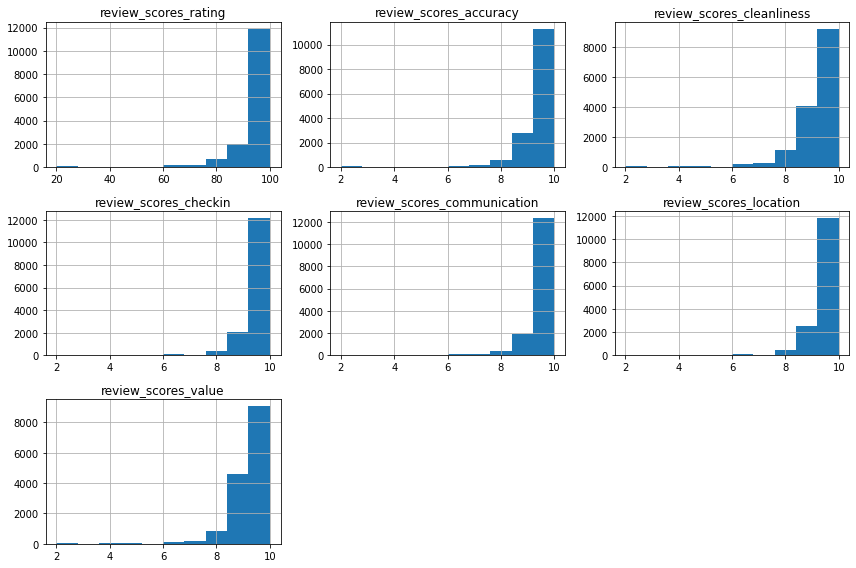

In [ ]:
# Checking the distributions of the review ratings columns in order to determine categories/bins
review_variables = list(cleaner_data.columns[cleaner_data.columns.str.startswith("review_scores") == True])
fig = plt.figure(figsize=(12,8))
for i, var_name in enumerate(review_variables):
    ax = fig.add_subplot(3,3,i+1)
    cleaner_data[var_name].hist(bins=10,ax=ax)
    ax.set_title(var_name)
fig.tight_layout()
plt.show()

In [ ]:
# store review_scores_rating_num as numerical
cleaned['review_scores_rating_num'] = cleaned['review_scores_rating']

In [ ]:
#since most of the observations are rates from 8-10, 0-8 can be one category
review_variables.pop(0)
for c in review_variables:
    make_categorical(c,
               bins=[0, 8, 9, 10],
               labels=['0-8/10', '9/10', '10/10'],
               na_label='no reviews')
    
make_categorical('review_scores_rating',
           bins=[0, 80, 95, 100],
           labels=['0-79/100', '80-94/100', '95-100/100'],
           na_label='no reviews')

In [ ]:
cleaned.loc[cleaned.new_price > 4000]

,id,host_since,host_response_rate,host_is_superhost,host_listings_count,host_identity_verified,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,availability_365,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,bath_num,new_price,host_number_days,time_since_first_review,time_since_last_review,property_type_real,air_conditioning,bbq,balcony_or_patio,nature_and_views,bed_linen,breakfast,tv,coffee_machine,cooking_basics,major_appliances,elevator,gym,parking,outdoor_space,host_greeting,hot_tub_sauna_or_pool,internet,long_term_stays,private_entrance,Fire_Safety,essentials,computer_workspace,fireplace,review_scores_rating_num
3831,13788645,2013-10-08,100%,f,1.0,t,Annex,43.67174,-79.39218,House,Entire home/apt,8,3.0,3.0,"[""Carbon monoxide alarm"", ""High chair"", ""Indoo...","$5,000.00",14,1125,365,17,2016-07-10,2019-10-09,95-100/100,10/10,10/10,10/10,10/10,10/10,10/10,f,4.0,5000.0,2548.0,4+ years,6-12 months,Entire villa,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,100.0
4761,16039481,2016-10-10,missing,f,4.0,f,Annex,43.67052,-79.39405,Apartment,Entire home/apt,8,4.0,4.0,"[""Carbon monoxide alarm"", ""Indoor fireplace"", ...","$13,164.00",1,1125,0,0,NaT,NaT,nan,nan,nan,nan,nan,nan,nan,f,3.5,13164.0,1450.0,nan,nan,Entire condominium,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,NaN
5292,17609051,2017-03-07,missing,f,1.0,f,Clanton Park,43.72899,-79.45805,House,Private room,1,1.0,1.0,"[""Carbon monoxide alarm"", ""TV"", ""Lock on bedro...","$7,500.00",3,3,365,0,NaT,NaT,nan,nan,nan,nan,nan,nan,nan,t,1.0,7500.0,1302.0,nan,nan,Private room in house,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,NaN
6659,20653172,2017-08-22,missing,f,2.0,f,Waterfront Communities-The Island,43.64906,-79.39130,Apartment,Entire home/apt,2,1.0,1.0,"[""Kitchen"", ""Air conditioning"", ""Essentials"", ...","$13,000.00",2,180,0,4,2017-09-04,2017-10-01,95-100/100,10/10,10/10,10/10,10/10,10/10,10/10,f,1.0,13000.0,1134.0,2-3 years,12+ months,Entire condominium,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,100.0
8110,23416911,2018-02-21,missing,f,0.0,f,Waterfront Communities-The Island,43.64461,-79.39693,Apartment,Entire home/apt,2,1.0,1.0,"[""Carbon monoxide alarm"", ""Kitchen"", ""Paid par...","$6,848.00",30,1125,0,28,2018-03-22,2020-02-21,95-100/100,10/10,10/10,10/10,10/10,10/10,10/10,f,1.0,6848.0,951.0,2-3 years,6-12 months,Entire loft,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,99.0
9714,27655068,2011-07-12,100%,f,9.0,t,Waterfront Communities-The Island,43.64876,-79.38952,Apartment,Entire home/apt,4,2.0,2.0,"[""Carbon monoxide alarm"", ""Private entrance"", ...","$9,000.00",5,1124,0,0,NaT,NaT,nan,nan,nan,nan,nan,nan,nan,f,1.0,9000.0,3367.0,nan,nan,Entire condominium,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,NaN
10136,28615622,2018-09-17,missing,f,1.0,f,Newtonbrook West,43.78772,-79.42835,House,Entire home/apt,4,2.0,3.0,"[""Carbon monoxide alarm"", ""Private entrance"", ...","$13,000.00",365,366,0,3,2018-10-01,2019-08-03,0-79/100,0-8/10,0-8/10,0-8/10,0-8/10,0-8/10,0-8/10,f,1.0,13000.0,743.0,1-2 years,12+ months,Entire bungalow,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,60.0
13723,36543469,2017-02-12,missing,f,6.0,f,Waterfront Communities-The Island,43.64399,-79.37988,Apartment,Entire home/apt,6,2.0,3.0,"[""Carbon monoxide alarm"", ""Shampoo"", ""Iron"", ""...","$10,000.00",30,1125,358,0,NaT,NaT,nan,nan,nan,nan,nan,nan,nan,f,1.0,10000.0,1325.0,nan,nan,Entire condominium,1.0,0.0,0.

In [ ]:
cleaned.loc[(cleaned.neighbourhood_cleansed == 'Waterfront Communities-The Island') & (cleaned.accommodates == 14)]

,id,host_since,host_response_rate,host_is_superhost,host_listings_count,host_identity_verified,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,availability_365,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,bath_num,new_price,host_number_days,time_since_first_review,time_since_last_review,property_type_real,air_conditioning,bbq,balcony_or_patio,nature_and_views,bed_linen,breakfast,tv,coffee_machine,cooking_basics,major_appliances,elevator,gym,parking,outdoor_space,host_greeting,hot_tub_sauna_or_pool,internet,long_term_stays,private_entrance,Fire_Safety,essentials,computer_workspace,fireplace,review_scores_rating_num
10282,29012612,2015-05-12,100%,f,5.0,t,Waterfront Communities-The Island,43.63878,-79.39867,Apartment,Entire home/apt,14,3.0,3.0,"[""Carbon monoxide alarm"", ""Private entrance"", ...",$265.00,1,99,356,33,2018-10-17,2020-07-01,80-94/100,10/10,9/10,10/10,10/10,10/10,9/10,f,3.0,265.0,1967.0,1-2 years,2-6 months,Entire condominium,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,93.0
16843,41860885,2020-01-26,0-49%,f,0.0,f,Waterfront Communities-The Island,43.63995,-79.39675,Apartment,Entire home/apt,14,3.0,7.0,"[""Carbon monoxide alarm"", ""Kitchen"", ""Shower g...",$79.00,1,1125,0,3,2020-02-18,2020-03-15,80-94/100,9/10,10/10,9/10,9/10,10/10,10/10,f,2.0,79.0,247.0,0.5-1 year,6-12 months,Entire condominium,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,93.0


In [ ]:
#removing nonsensical observations
cleaned.drop(cleaned[(cleaned['id'] == 17609051) | (cleaned['id'] == 28615622) | (cleaned['id'] ==  41432548)| (cleaned['id'] ==  29012612) | (cleaned['id'] ==  41860885)].index, inplace = True) 

##Exploratory Data Analysis

***Price Distribiution***

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


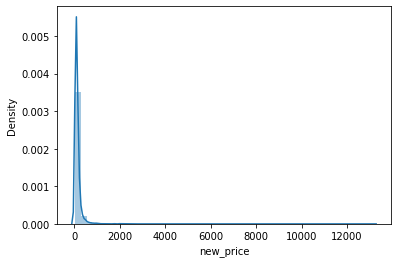

Max nightly price $13,164.00.
Min nightly price $12.00.


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


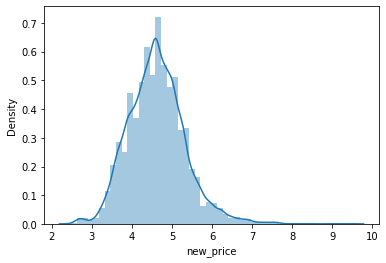

141.27298722788154
100.0


In [ ]:
sns.distplot(cleaner_data.new_price)
plt.show()
print(f"Max nightly price ${max(cleaner_data.new_price):,.2f}.")
print(f"Min nightly price ${min(cleaner_data.new_price):.2f}.")
#price is heavily right-skewed so we will use the log of price

logprice = np.log(cleaner_data.new_price)
sns.distplot(logprice)
plt.show()
print(np.mean(cleaner_data.new_price))
print(np.median(cleaner_data.new_price))


***Number of listings per host***

In [ ]:
#replacing where it says the host has 0 listings with 1 listing
cleaner_data.host_listings_count = np.where(cleaner_data.host_listings_count==0.0, 1.0, cleaner_data.host_listings_count)

In [ ]:
print("Max number of listings per host:", int(cleaner_data.host_listings_count.max()))
print("Median number of listings per host:", int(cleaner_data.host_listings_count.median()))
print("Mean number of listings per host:", int(round(cleaner_data.host_listings_count.mean())))

Max number of listings per host: 272
Median number of listings per host: 1
Mean number of listings per host: 6


***Time exploration***

In [ ]:
print(f"Earliest listing date: {min(cleaner_data.host_since).strftime('%d %B %Y')}.")
print(f"Most recent listing date:{max(cleaner_data.host_since).strftime('%d %B %Y')}.")
print(f"Earliest first review date: {min(cleaner_data.first_review).strftime('%d %B %Y')}.")
print(f"Most recent first review date:{max(cleaner_data.first_review).strftime('%d %B %Y')}.")
print(f"Most recent last review date:{max(cleaner_data.last_review).strftime('%d %B %Y')}.")

Earliest listing date: 08 August 2008.
Most recent listing date:07 September 2020.
Earliest first review date: 20 August 2009.
Most recent first review date:10 September 2020.
Most recent last review date:10 September 2020.


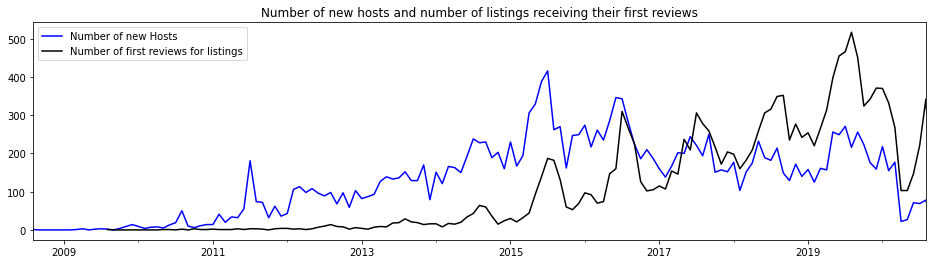

In [ ]:
#historical look at number of listings
plt.figure(figsize=(16,4))
cleaner_data.set_index('host_since').resample('M').size().plot(label='Number of new Hosts', color='blue')
cleaner_data.set_index('first_review').resample('M').size().plot(label='Number of first reviews for listings', color= 'black')
plt.title('Number of new hosts and number of listings receiving their first reviews')
plt.legend()
plt.xlim('2008-08-01', '2020-08-31') 
plt.xlabel('')
plt.ylabel('')
plt.show()

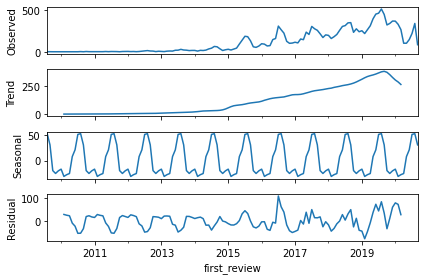

In [ ]:
cleaner_data.first_review = pd.to_datetime(cleaner_data.first_review)
ts_first_rev = pd.DataFrame(cleaner_data.set_index('first_review').resample('M').size())
ts_first_rev.index.rename('m')

decomposition = seasonal_decompose(ts_first_rev)
decomposition.plot();
plt.savefig('drive/My Drive/FNCE 237 Final Project/reviewdata.png')



/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


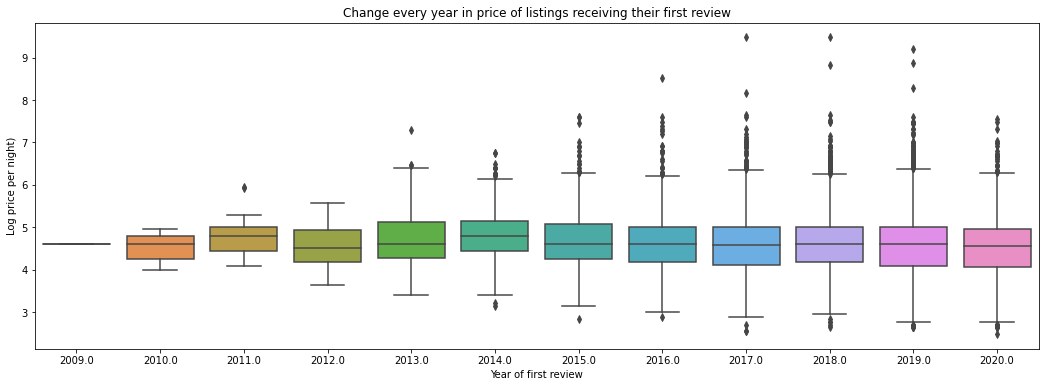

In [ ]:

plt.figure(figsize=(18,6))
sns.boxplot(cleaner_data.first_review.dt.year, np.log(cleaner_data.new_price))
plt.xlabel('Year of first review')
plt.ylabel('Log price per night)')
plt.title('Change every year in price of listings receiving their first review')
plt.show()


In [ ]:
a=cleaner_data[['id','first_review','new_price']]
a=a.sort_values('first_review').dropna()
a['cum_price']=a['new_price'].cumsum()
a['const']=1
a['cn']=a.const.cumsum()
a['cum_avg']=a.cum_price/a.cn  #cummulative average price of listings
#a.head()


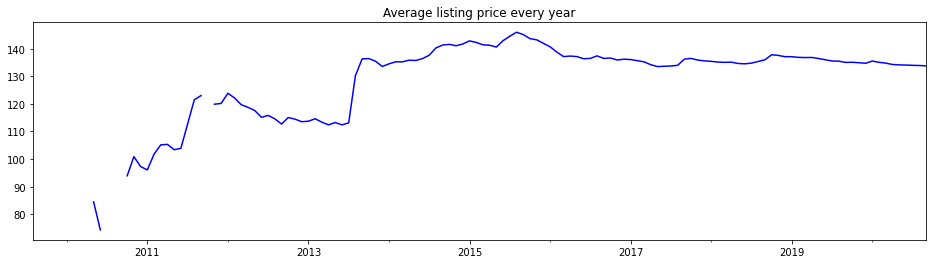

In [ ]:
#looking at average price of listings over time
plt.figure(figsize=(16,4))
a.set_index('first_review').cum_avg.resample('M').mean().plot(color= 'blue')
plt.title('Average listing price every year')
plt.xlim('2009-08-01', '2020-09-30') 
plt.xlabel('')
plt.ylabel('')
plt.show()

***Reviews and Listing Price***

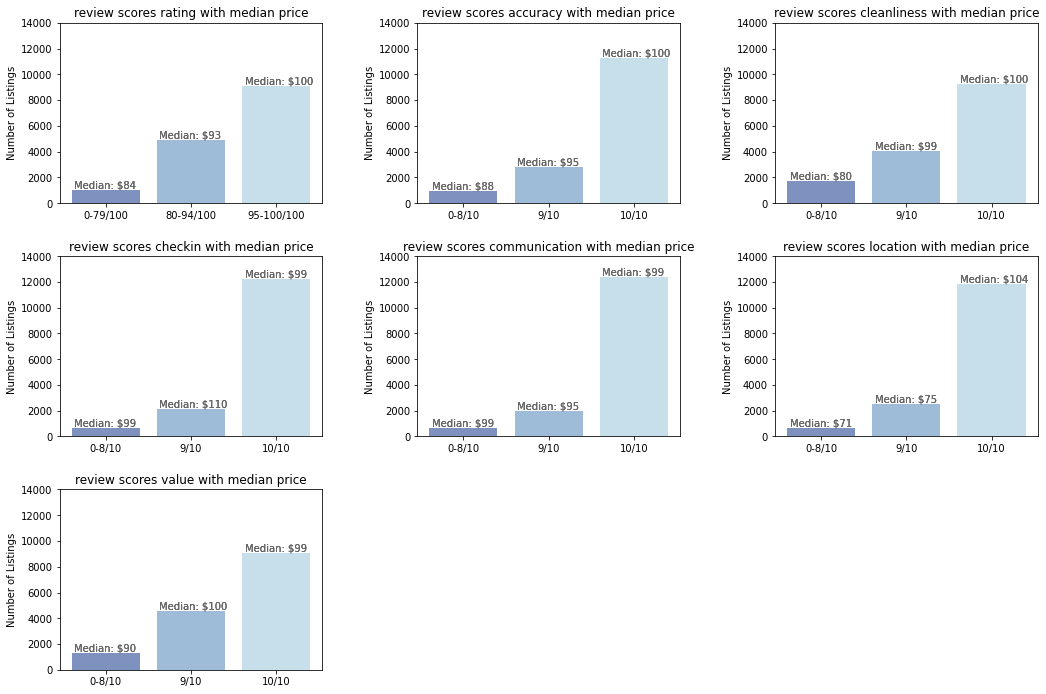

In [ ]:
#  review variable plots with median price
review_variables = list(cleaner_data.columns[cleaner_data.columns.str.startswith("review_scores") == True])
fig = plt.figure(figsize=(15,10))
for i, var_name in enumerate(review_variables):
    
    # get rid of nan values
    mask = cleaned[var_name].str.contains('nan')
    no_nan_data = cleaned[var_name][~mask]
    
    # count and median each bucket
    buckets = no_nan_data.unique()
    bin_count = []
    bin_median = []
    for b in buckets:
        # get target data
        mask1 = no_nan_data == b
        bin_data = no_nan_data[mask1]
        # count
        count = len(bin_data)
        bin_count.append(count)  
        # median price
        mask2 = cleaned[var_name] == b
        b_median = np.median(cleaned.new_price[mask2])
        bin_median.append("$" + str(b_median)[0:-2])
    
    # plot 
    ax = fig.add_subplot(3,3,i+1)
    ax.bar(buckets, bin_count, color = sns.color_palette("ch:s=.25,rot=-.25"))
    ax.set_ylabel('Number of Listings')
    plt.yticks(np.arange(0, 16_000, step = 2000))
    plt.gca().invert_xaxis()
    
    # MEDIAN LABELS
    # create a list to collect the plt.patches data
    totals = [] 
    # find the values and append to list
    for i1 in ax.patches:
        totals.append(i1.get_height())
        # set individual bar lables using above list
        total = sum(totals)
        # Plot median labels
        for i2 in range(0,len(bin_median)):
            ax.text(ax.patches[i2].get_x()+.77, ax.patches[i2].get_height()+150, \
            'Median: ' + str(bin_median[i2]), fontsize=10, color='dimgrey')
    
    # title graph
    ax.set_title("review scores " + var_name[14:] + ' with median price')

fig.tight_layout(pad=2)
plt.show()

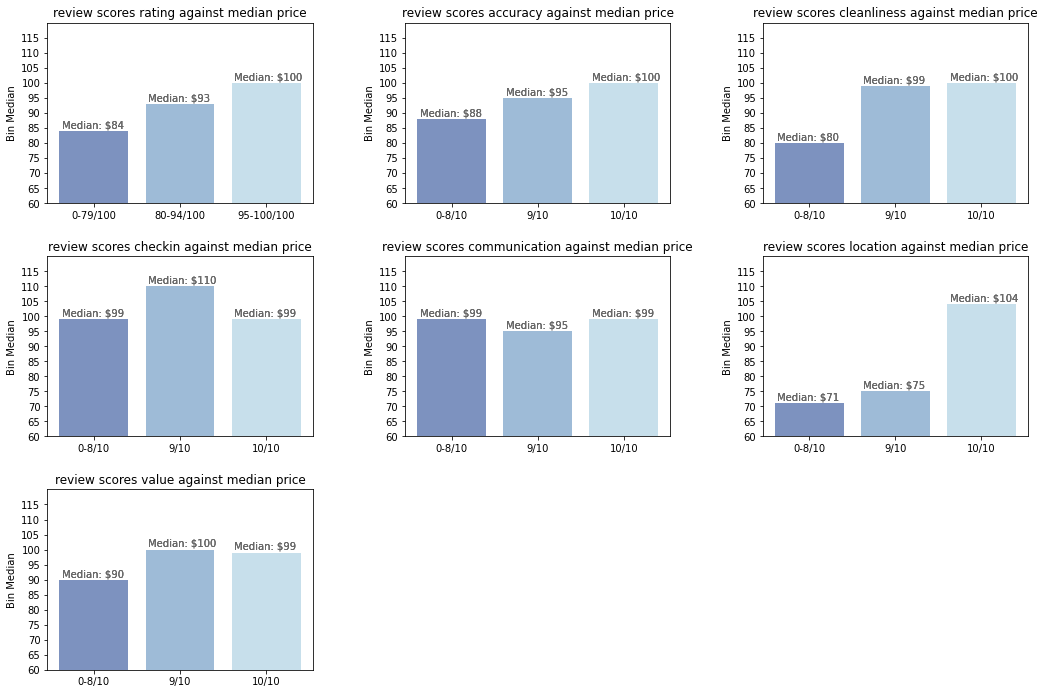

In [ ]:
#  review variable plots with median price
review_variables = list(cleaner_data.columns[cleaner_data.columns.str.startswith("review_scores") == True])
fig = plt.figure(figsize=(15,10))
for i, var_name in enumerate(review_variables):
    
    # get rid of nan values
    mask = cleaned[var_name].str.contains('nan')
    no_nan_data = cleaned[var_name][~mask]
    
    # count and median each bucket
    buckets = no_nan_data.unique()
    bin_count = []
    bin_median = []
    bin_median_label = []
    for b in buckets:
        # get target data
        mask1 = no_nan_data == b
        bin_data = no_nan_data[mask1] 
        # median price
        mask2 = cleaned[var_name] == b
        b_median = np.median(cleaned.new_price[mask2])
        bin_median.append(b_median)
        bin_median_label.append("$" + str(b_median)[0:-2])

      
    # plot 
    ax = fig.add_subplot(3,3,i+1)
    ax.bar(buckets, bin_median, color = sns.color_palette("ch:s=.25,rot=-.25"))
    ax.set_ylabel('Bin Median')
    plt.yticks(np.arange(60, 120, step = 5))
    plt.gca().invert_xaxis()
    ax.set_ylim([60, 120])

    # MEDIAN LABELS
    # create a list to collect the plt.patches data
    totals = [] 
    # find the values and append to list
    for i1 in ax.patches:
        totals.append(i1.get_height())
        # set individual bar lables using above list
        total = sum(totals)
        # Plot median labels
        for i2 in range(0,len(bin_median)):
            ax.text(ax.patches[i2].get_x()+.77, ax.patches[i2].get_height()+1, \
            'Median: ' + str(bin_median_label[i2]), fontsize=10, color='dimgrey')
    
    # title graph
    ax.set_title("review scores " + var_name[14:] + ' against median price')

fig.tight_layout(pad=2)
plt.show()

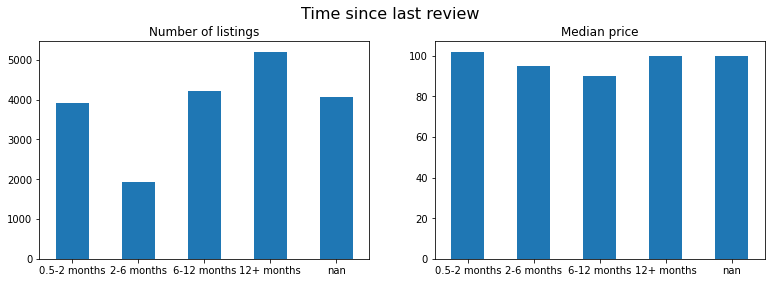

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13,4))
fig.suptitle('Time since last review', fontsize=16, y=1)
    
cleaned['time_since_last_review'].value_counts().reindex(['0.5-2 months', '2-6 months', '6-12 months', '12+ months', 'nan']).plot(kind='bar', ax=ax1)
ax1.tick_params(labelrotation=0)
ax1.set_title('Number of listings')
ax1.set_xlabel('')
    
cleaned.groupby('time_since_last_review').new_price.median().reindex(['0.5-2 months', '2-6 months', '6-12 months', '12+ months', 'nan']).plot(kind='bar', ax=ax2)
ax2.set_title('Median price')
ax2.set_xlabel('')
ax2.tick_params(labelrotation=0)
plt.show()

###Variables to explore

Final Dictionary of Variables to explore

* **new_price** - nightly advertised price (our dependent variable)
* Geographical variables: 
  * Neighbourhoods_cleansed: 140 neighbourhoods of Toronto
* Host variables
  * host_response_rate - percentage of messages tow which the host responds 
  * host_number_days - number of days since host joined airbnb
  * host_is_superhost - whether or not the host is a superhost
  * host_identity_verified - if host has been verified with id
* property_type - type of property, e.g. house or apartment
*Booking Constraints
  * minimum_nights - minimum amount of nights for stay
  * instant_bookable - whether or not the property can be instantly booked
* Size variables:
  * room_type - amount of space, e.g. entire home/private room/shared room
  * accommodates - how many people the property accommodates
  * bath_num - number of bathrooms
  * bedrooms - number of bedrooms
  * beds - number of beds
* amenities:
  * air_conditioning
  * balcony_or_patio
  * bed_linen
  * tv
  * coffee_machine
  * cooking_basics
  * major_appliances
  * elevator
  * gym
  * parking
  * outdoor_space
  * fire_safety
  * hot_tub_sauna_or_pool
  * internet
  * private_entrance
  * bbq
  * nature_and_views
  * breakfast
  * fireplace
  * computer_workspace






In [ ]:
#dropping unnecessary columns and extra review columns that will probably be correlated
cleaned_= cleaned.drop(['latitude', 'longitude', 'amenities','price',
               'first_review', 'last_review', 'number_of_reviews','id', 'host_since', 'maximum_nights', 'review_scores_rating_num',
               'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_accuracy', 'review_scores_location', 'review_scores_value',
   'review_scores_communication', 'host_listings_count', 'property_type_real','review_scores_checkin','time_since_first_review' ], axis=1)

In [ ]:
cleaned_dum = pd.get_dummies(cleaned_)
cleaned_dum['log_price']=np.log(cleaned_dum['new_price'])


In [ ]:
#review variables we later need to control for
review_s= list(cleaned_dum.columns[cleaned_dum.columns.str.startswith('review_scores_rating')])
review_s.remove('review_scores_rating_nan')
review_t = list(cleaned_dum.columns[cleaned_dum.columns.str.startswith('time_since_last_review')])
review_t.remove('time_since_last_review_nan')
xvars_review = review_s + review_t
xvars_review

['review_scores_rating_0-79/100',
 'review_scores_rating_80-94/100',
 'review_scores_rating_95-100/100',
 'time_since_last_review_0.5-2 months',
 'time_since_last_review_12+ months',
 'time_since_last_review_2-6 months',
 'time_since_last_review_6-12 months']

In [ ]:
cleaned_dum.head()

,accommodates,bedrooms,beds,minimum_nights,availability_365,bath_num,new_price,host_number_days,air_conditioning,bbq,balcony_or_patio,nature_and_views,bed_linen,breakfast,tv,coffee_machine,cooking_basics,major_appliances,elevator,gym,parking,outdoor_space,host_greeting,hot_tub_sauna_or_pool,internet,long_term_stays,private_entrance,Fire_Safety,essentials,computer_workspace,fireplace,host_response_rate_0-49%,host_response_rate_100%,host_response_rate_50-89%,host_response_rate_90-99%,host_response_rate_missing,host_is_superhost_f,...,neighbourhood_cleansed_Waterfront Communities-The Island,neighbourhood_cleansed_West Hill,neighbourhood_cleansed_West Humber-Clairville,neighbourhood_cleansed_Westminster-Branson,neighbourhood_cleansed_Weston,neighbourhood_cleansed_Weston-Pellam Park,neighbourhood_cleansed_Wexford/Maryvale,neighbourhood_cleansed_Willowdale East,neighbourhood_cleansed_Willowdale West,neighbourhood_cleansed_Willowridge-Martingrove-Richview,neighbourhood_cleansed_Woburn,neighbourhood_cleansed_Woodbine Corridor,neighbourhood_cleansed_Woodbine-Lumsden,neighbourhood_cleansed_Wychwood,neighbourhood_cleansed_Yonge-Eglinton,neighbourhood_cleansed_Yonge-St.Clair,neighbourhood_cleansed_York University Heights,neighbourhood_cleansed_Yorkdale-Glen Park,property_type_Apartment,property_type_Hotel,property_type_House,property_type_Other Type,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,review_scores_rating_0-79/100,review_scores_rating_80-94/100,review_scores_rating_95-100/100,review_scores_rating_nan,instant_bookable_f,instant_bookable_t,time_since_last_review_0.5-2 months,time_since_last_review_12+ months,time_since_last_review_2-6 months,time_since_last_review_6-12 months,time_since_last_review_nan,log_price
0,10,5.0,7.0,4,0,3.0,469.0,4435.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,1,0,0,0,6.150603
1,2,1.0,1.0,180,365,1.5,99.0,4117.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0,0,0,0,1,1,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,4.595120
2,1,1.0,1.0,1,0,1.5,66.0,3992.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,0,1,4.189655
3,3,1.0,1.0,1,209,1.0,70.0,3851.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,4.248495
4,5,1.0,2.0,21,216,1.0,135.0,3810.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0,1,0,0,0,1,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,4.905275


##How does geographical location affect listing price?

In [ ]:
#neighbourhood variables
neighbourhoods =list(cleaned_dum.columns[cleaned_dum.columns.str.startswith('neighbourhood')])
neighbourhoods.remove('neighbourhood_cleansed_Alderwood')


In [ ]:
#getting the geospatial data
geo_data_file='drive/My Drive/FNCE 237 Final Project/Neighbourhoods.geojson'
geo = gpd.read_file(geo_data_file)

col_drop =['AREA_ID','AREA_ATTR_ID','AREA_DESC','PARENT_AREA_ID','AREA_SHORT_CODE','X', 'Y','AREA_LONG_CODE','OBJECTID']
geo_cleaned= geo.drop(col_drop, axis=1)
geo_cleaned.rename(columns={'AREA_NAME': 'neighbourhood_cleansed'}, inplace=True)
geo_cleaned['neighbourhood_cleansed'] = geo_cleaned.neighbourhood_cleansed.str.replace(r"\(.*\)","")
geo_cleaned['neighbourhood_cleansed']=geo_cleaned.neighbourhood_cleansed.str.strip()
geo_cleaned.head(2)

,_id,neighbourhood_cleansed,LONGITUDE,LATITUDE,Shape__Area,Shape__Length,geometry
0,7841,Wychwood,-79.425515,43.676919,3.217960e+06,7515.779658,"POLYGON ((-79.43592 43.68015, -79.43492 43.680..."
1,7842,Yonge-Eglinton,-79.403590,43.704689,3.160334e+06,7872.021074,"POLYGON ((-79.41096 43.70408, -79.40962 43.704..."


In [ ]:
#dataframe of amount of listings and mean price by neighborhood
neigh = pd.DataFrame(cleaner_data.groupby('neighbourhood_cleansed').size())

neigh=neigh.rename(columns={0: 'no_listings'})
neigh['mean_price'] = cleaner_data.groupby('neighbourhood_cleansed').new_price.mean()
neigh['med_price'] = cleaner_data.groupby('neighbourhood_cleansed').new_price.median()
neigh=neigh.reset_index()

# Merging the dataframes
neighbourhood_map= pd.merge(geo_cleaned, neigh, on='neighbourhood_cleansed', how='outer')

In [ ]:
b=neigh.no_listings.argmax()
print("Neighbourhood with the greatest number of listings:",(neigh.iloc[b][0]))
c=neigh.mean_price.argmax()
print("Neighbourhood with the highest mean price of listings:",(neigh.iloc[c][0]))
d=neigh.med_price.argmax()
print("Neighbourhood with the highest median price of listings:",(neigh.iloc[d][0]))

Neighbourhood with the greatest number of listings: Waterfront Communities-The Island
Neighbourhood with the highest mean price of listings: Woburn
Neighbourhood with the highest median price of listings: Waterfront Communities-The Island


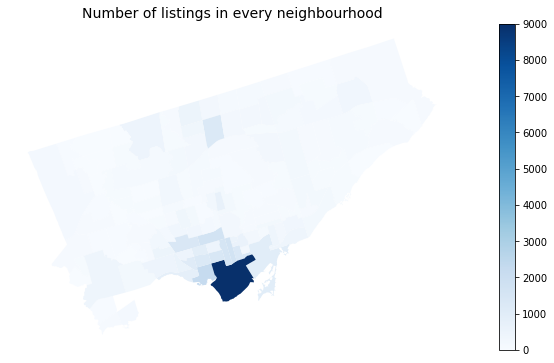

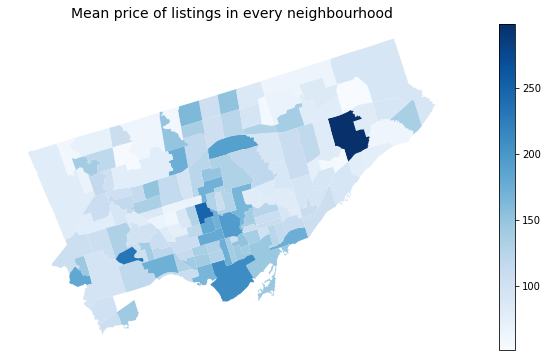

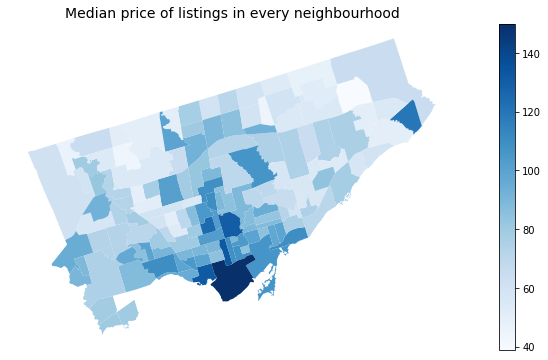

In [ ]:

# map based on number of listings
fig1, ax1 = plt.subplots(1, figsize=(15, 6))
neighbourhood_map.plot(column='no_listings', cmap='Blues', ax=ax1)
ax1.axis('off')
ax1.set_title('Number of listings in every neighbourhood', fontsize=14)
so = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=0, vmax=9000))
so._A = [] 
cbar = fig1.colorbar(so)
plt.show()

# map based on the mean price
fig2, ax2 = plt.subplots(1, figsize=(15, 6))
neighbourhood_map.plot(column='mean_price', cmap='Blues', ax=ax2)
ax2.axis('off')
ax2.set_title('Mean price of listings in every neighbourhood', fontsize=14)
so = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=min(neighbourhood_map.mean_price), vmax=max(neighbourhood_map.mean_price)))
so._A = []
cbar = fig2.colorbar(so)
plt.show()

# map based on the median price

fig3, ax3 = plt.subplots(1, figsize=(15, 6))
neighbourhood_map.plot(column='med_price', cmap='Blues', ax=ax3)
ax3.axis('off')
ax3.set_title('Median price of listings in every neighbourhood', fontsize=14)
sj = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=min(neighbourhood_map.med_price), vmax=max(neighbourhood_map.med_price)))
sj._A = []
cbar = fig3.colorbar(sj)
plt.show()

In [ ]:

cleaner_data['year']=cleaner_data.first_review.dt.year 

mask = (cleaner_data.year==2019) | (cleaner_data.year==2020)
time_df=cleaner_data.loc[mask, ['id', 'neighbourhood_cleansed', 'year']]

time_df=time_df.sort_values('year')


In [ ]:
x= pd.DataFrame(time_df.groupby(['neighbourhood_cleansed','year']).size())
x=x.rename(columns={0: 'no_listings'})

x['cum_no']=x.groupby('neighbourhood_cleansed')['no_listings'].cumsum()
x['growth']=x.cum_no/x.groupby('neighbourhood_cleansed')['cum_no'].shift(1)-1
x=x.dropna(subset=['growth'])

# Merging the dataframes
neighbourhood_growth_map= pd.merge(geo_cleaned, x, on='neighbourhood_cleansed', how='outer')

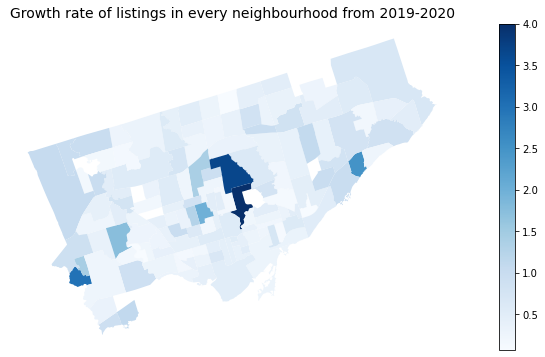

In [ ]:
# map based on number of listings
fig1, ax1 = plt.subplots(1, figsize=(15, 6))
neighbourhood_growth_map.plot(column='growth', cmap='Blues', ax=ax1)
ax1.axis('off')
ax1.set_title('Growth rate of listings in every neighbourhood from 2019-2020', fontsize=14)
so = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=min(neighbourhood_growth_map.growth), vmax=max(neighbourhood_growth_map.growth)))
so._A = [] 
cbar = fig1.colorbar(so)
plt.show()

In [ ]:
x=x.reset_index()
g=x.growth.argmax()
print(f"Despite the pandemic, {x.iloc[g][0]} had the most growth in listings with new first-time reviews: {max(x.growth):.0f} times")

Despite the pandemic, Leaside-Bennington had the most growth in listings with new first-time reviews: 4 times


In [ ]:
#model with neighbourhoods
res = sm.OLS(cleaned_dum['log_price'],sm.add_constant(cleaned_dum[neighbourhoods]),missing='drop').fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.193
Model:                            OLS   Adj. R-squared:                  0.188
Method:                 Least Squares   F-statistic:                     33.12
Date:                Thu, 26 Nov 2020   Prob (F-statistic):               0.00
Time:                        17:30:50   Log-Likelihood:                -18782.
No. Observations:               19334   AIC:                         3.784e+04
Df Residuals:                   19194   BIC:                         3.895e+04
Df Model:                         139                                         
Covariance Type:            nonrobust                                         
==============================================================================================================================
                                                                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------
const                                                          4.4307      0.126     35.215      0.000       4.184       4.677
neighbourhood_cleansed_Agincourt North                        -0.3031      0.163     -1.856      0.063      -0.623       0.017
neighbourhood_cleansed_Agincourt South-Malvern West           -0.3385      0.144     -2.351      0.019      -0.621      -0.056
neighbourhood_cleansed_Annex                                   0.3121      0.128      2.431      0.015       0.060       0.564
neighbourhood_cleansed_Banbury-Don Mills                       0.1237      0.153      0.808      0.419      -0.176       0.424
neighbourhood_cleansed_Bathurst Manor                          0.1860      0.162      1.151      0.250      -0.131       0.503
neighbourhood_cleansed_Bay Street Corridor                     0.4532      0.129      3.524      0.000       0.201       0.705
neighbourhood_cleansed_Bayview Village                         0.0681      0.140      0.485      0.628      -0.207       0.343
neighbourhood_cleansed_Bayview Woods-Steeles                  -0.0514      0.149     -0.344      0.731      -0.344       0.241
neighbourhood_cleansed_Bedford Park-Nortown                   -0.3430      0.149     -2.299      0.022      -0.635      -0.051
neighbourhood_cleansed_Beechborough-Greenbrook                -0.2173      0.231     -0.942      0.346      -0.670       0.235
neighbourhood_cleansed_Bendale                                -0.1691      0.151     -1.123      0.261      -0.464       0.126
neighbourhood_cleansed_Birchcliffe-Cliffside                  -0.0784      0.142     -0.554      0.580      -0.356       0.199
neighbourhood_cleansed_Black Creek                            -0.3480      0.191     -1.824      0.068      -0.722       0.026
neighbourhood_cleansed_Blake-Jones                             0.0450      0.148      0.304      0.761      -0.246       0.336
neighbourhood_cleansed_Briar Hill-Belgravia                   -0.3539      0.148     -2.393      0.017      -0.644      -0.064
neighbourhood_cleansed_Bridle Path-Sunnybrook-York Mills       0.0323      0.176      0.183      0.855      -0.313       0.378
neighbourhood_cleansed_Broadview North                         0.1200      0.151      0.797      0.426      -0.175       0.415
neighbourhood_cleansed_Brookhaven-Amesbury                    -0.2305      0.162     -1.419      0.156      -0.549       0.088
neighbourhood_cleansed_Cabbagetown-South St.James Town         0.3141      0.133      2.368      0.018       0.054       0.574
neighbourhood_cleansed_Caledonia-Fairbank                     -0.4498      0.156     -2.879      0.004      -0.756      -0.144
neighbourhood_cleansed_Casa Loma   

##How does property type affect price of listing?

In [ ]:
#property type Variables
xvars_prop_type= list(cleaned_dum.columns[cleaned_dum.columns.str.startswith('property_type')])
xvars_prop_type.remove('property_type_Apartment')

In [ ]:
cleaner_data.groupby('property_type').new_price.describe()

,count,mean,std,min,25%,50%,75%,max
property_type,,,,,,,,
Apartment,11293.0,151.530753,318.671388,12.0,80.0,113.000,161.0,13164.0
Hotel,163.0,160.645276,113.594222,30.0,91.0,109.000,195.5,624.0
House,7789.0,126.464838,248.397869,12.0,49.0,75.000,129.0,13000.0
Other Type,94.0,102.358617,132.803041,13.0,36.0,73.855,100.0,900.0


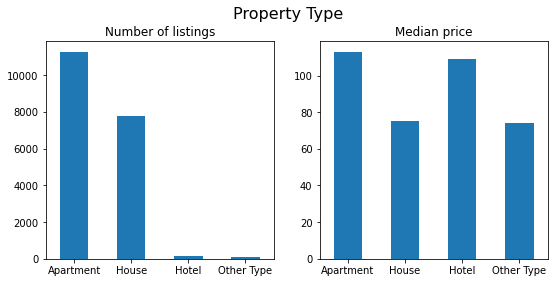

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9,4))
fig.suptitle('Property Type', fontsize=16, y=1)
    
cleaner_data['property_type'].value_counts().reindex(['Apartment', 'House', 'Hotel', 'Other Type']).plot(kind='bar', ax=ax1)
ax1.tick_params(labelrotation=0)
ax1.set_title('Number of listings')
ax1.set_xlabel('')
    
cleaner_data.groupby('property_type').new_price.median().reindex(['Apartment', 'House', 'Hotel', 'Other Type']).plot(kind='bar', ax=ax2)

ax2.set_title('Median price')
ax2.set_xlabel('')
ax2.tick_params(labelrotation=0)
plt.show()
#print(cleaner_data['property_type'].value_counts(normalize=True))

In [ ]:
#model of property type variables
res = sm.OLS(cleaned_dum['log_price'],sm.add_constant(cleaned_dum[xvars_prop_type]),missing='drop').fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.049
Model:                            OLS   Adj. R-squared:                  0.049
Method:                 Least Squares   F-statistic:                     332.4
Date:                Thu, 26 Nov 2020   Prob (F-statistic):          1.86e-210
Time:                        17:30:51   Log-Likelihood:                -20373.
No. Observations:               19334   AIC:                         4.075e+04
Df Residuals:                   19330   BIC:                         4.079e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                        4.7476      0.007    726.724      0.000       4.735       4.760
property_type_Hotel          0.1205      0.055      2.201      0.028       0.013       0.228
property_type_House         -0.3146      0.010    -30.764      0.000      -0.335      -0.295
property_type_Other Type    -0.5187      0.072     -7.216      0.000      -0.660      -0.378
==============================================================================
Omnibus:                     2487.575   Durbin-Watson:                   1.882
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5524.217
Skew:                           0.775   Prob(JB):                         0.00
Kurtosis:                       5.110   Cond. No.                         15.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

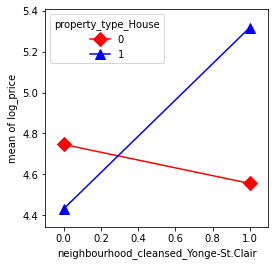

In [ ]:
fig, ax = plt.subplots(figsize=(4, 4))
fig = interaction_plot(x=cleaned_dum['neighbourhood_cleansed_Yonge-St.Clair'], trace=cleaned_dum['property_type_House'], response=cleaned_dum['log_price'],
                       colors=['red', 'blue'], markers=['D', '^'], ms=10, ax=ax)
plt.show()

In [ ]:
cleaned_dum['house*Yonge_stclair']=cleaned_dum['property_type_House']*cleaned_dum['neighbourhood_cleansed_Yonge-St.Clair']
cleaned_dum['house*baystreet']=cleaned_dum['property_type_House']*cleaned_dum['neighbourhood_cleansed_Bay Street Corridor']
cleaned_dum['house*Yonge_church']=cleaned_dum['property_type_House']*cleaned_dum['neighbourhood_cleansed_Church-Yonge Corridor']
cleaned_dum['house*Uni']=cleaned_dum['property_type_House']*cleaned_dum['neighbourhood_cleansed_University']
cleaned_dum['house*bathurst']=cleaned_dum['property_type_House']*cleaned_dum['neighbourhood_cleansed_Bathurst Manor']
cleaned_dum['house*Annex']=cleaned_dum['property_type_House']*cleaned_dum['neighbourhood_cleansed_Annex']
interactions_house=['house*Yonge_stclair', 'house*baystreet', 'house*Yonge_church', 'house*Uni', 'house*bathurst', 'house*Annex']

##How does size affect listing price?

In [ ]:
#size variables
room_type_= (list(cleaned_dum.columns[cleaned_dum.columns.str.startswith('room_type')]))
xvars_size=['accommodates', 'bath_num', 'bedrooms', 'beds']+room_type_
xvars_size.remove('room_type_Shared room')
xvars_size

['accommodates',
 'bath_num',
 'bedrooms',
 'beds',
 'room_type_Entire home/apt',
 'room_type_Private room']

***Median price of listings based on capacity***

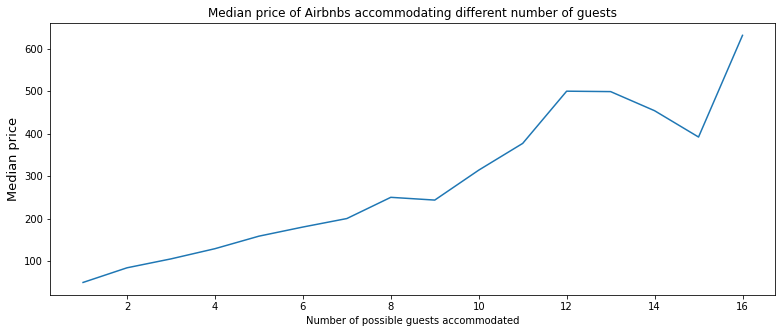

In [ ]:
plt.figure(figsize=(13,5))
cleaner_data.groupby('accommodates').new_price.median().plot()
plt.title('Median price of Airbnbs accommodating different number of guests')
plt.xlabel('Number of possible guests accommodated')
plt.ylabel('Median price', fontsize=13)
plt.xticks()
plt.xlim()
plt.show()

In [ ]:
cleaner_data.groupby('accommodates').new_price.describe()

,count,mean,std,min,25%,50%,75%,max
accommodates,,,,,,,,
1,2748.0,69.084916,172.415445,12.0,35.0000,49.5,69.0000,7500.00
2,8098.0,105.304795,207.848383,14.0,58.0000,84.0,119.0000,13000.00
3,1941.0,130.980685,174.578257,13.0,80.0000,105.0,147.0000,3958.00
4,3538.0,174.515910,407.755402,20.0,98.0000,129.0,180.0000,13000.00
5,860.0,193.724919,211.541238,12.0,120.0000,158.5,210.0000,5000.00
6,1218.0,235.237373,338.965066,23.0,130.0725,180.0,263.0000,10000.00
7,193.0,264.935181,198.498665,41.0,150.0000,200.0,320.7100,1745.00
8,384.0,358.284844,732.999088,16.0,171.7500,250.0,382.5725,13164.00
9,56.0,293.076429,210.549372,30.0,185.7500,243.5,324.7500,1084.71


***Median prices based on amount of space***

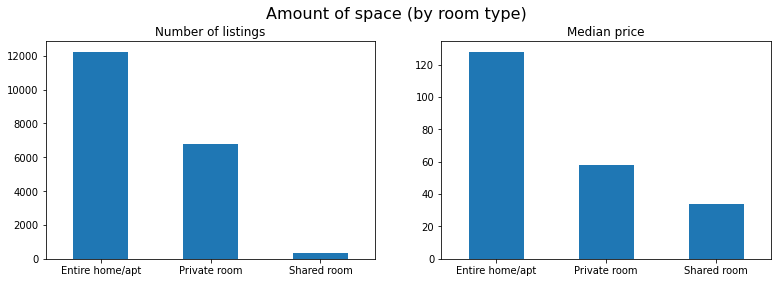

Entire home/apt    0.632763
Private room       0.349294
Shared room        0.017943
Name: room_type, dtype: float64


In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13,4))
fig.suptitle('Amount of space (by room type)', fontsize=16, y=1)
    
cleaner_data['room_type'].value_counts().plot(kind='bar', ax=ax1)
ax1.tick_params(labelrotation=0)
ax1.set_title('Number of listings')
ax1.set_xlabel('')
    
cleaner_data.groupby('room_type').new_price.median().plot(kind='bar', ax=ax2)
ax2.set_title('Median price')
ax2.set_xlabel('')
ax2.tick_params(labelrotation=0)
plt.show()
print(cleaner_data['room_type'].value_counts(normalize=True))

In [ ]:
cleaner_data.groupby('room_type').new_price.describe()

,count,mean,std,min,25%,50%,75%,max
room_type,,,,,,,,
Entire home/apt,12237.0,179.880413,347.681469,12.0,95.0,128.0,185.0,13164.0
Private room,6755.0,75.485859,119.850517,13.0,43.0,58.0,80.0,7500.0
Shared room,347.0,60.445850,154.004745,12.0,16.0,34.0,51.5,2429.0


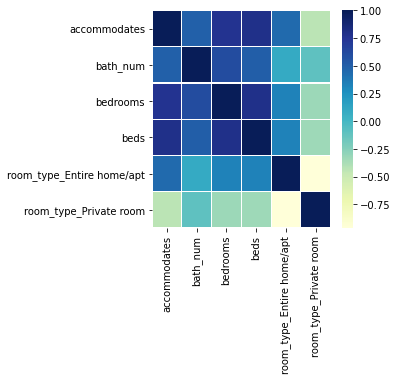

In [ ]:
size_df = cleaned_dum.filter(xvars_size, axis=1)
corrmat = size_df.corr()
f, ax = plt.subplots(figsize =(4, 4)) 
sns.heatmap(corrmat, annot=False, ax = ax, cmap ="YlGnBu", linewidths = 0.1)

plt.show()


In [ ]:
#since accommodates, bedroom, beds, and bath_num are highly correlated, we will only keep accomodates
drop = ['bedrooms', 'beds', 'bath_num']
xvars_size = [e for e in xvars_size if e not in drop]

In [ ]:
#model of size variables
res = sm.OLS(cleaned_dum['log_price'],sm.add_constant(cleaned_dum[xvars_size]),missing='drop').fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.461
Model:                            OLS   Adj. R-squared:                  0.461
Method:                 Least Squares   F-statistic:                     5520.
Date:                Thu, 26 Nov 2020   Prob (F-statistic):               0.00
Time:                        17:30:52   Log-Likelihood:                -14878.
No. Observations:               19334   AIC:                         2.976e+04
Df Residuals:                   19330   BIC:                         2.979e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         3.3509      0.028    118.692      0.000       3.296       3.406
accommodates                  0.1403      0.002     67.536      0.000       0.136       0.144
room_type_Entire home/apt     1.0513      0.029     36.508      0.000       0.995       1.108
room_type_Private room        0.4989      0.029     17.347      0.000       0.443       0.555
==============================================================================
Omnibus:                     5461.340   Durbin-Watson:                   1.860
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            27446.039
Skew:                           1.279   Prob(JB):                         0.00
Kurtosis:                       8.247   Cond. No.                         49.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

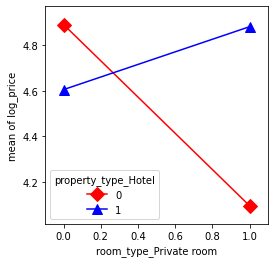

In [ ]:
cleaned_dum['private_room*Hotel']=cleaned_dum['property_type_Hotel']*cleaned_dum['room_type_Private room']

fig, ax = plt.subplots(figsize=(4, 4))
fig = interaction_plot(x=cleaned_dum['room_type_Private room'], trace=cleaned_dum['property_type_Hotel'], response=cleaned_dum['log_price'],
                       colors=['red', 'blue'], markers=['D', '^'], ms=10, ax=ax)
plt.show()

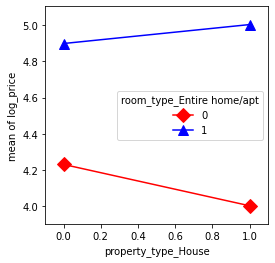

In [ ]:
cleaned_dum['entire*House']=cleaned_dum['property_type_House']*cleaned_dum['room_type_Entire home/apt']

fig, ax = plt.subplots(figsize=(4, 4))
fig = interaction_plot(x=cleaned_dum['property_type_House'], trace=cleaned_dum['room_type_Entire home/apt'], response=cleaned_dum['log_price'],
                       colors=['red', 'blue'], markers=['D', '^'], ms=10, ax=ax)
plt.show()

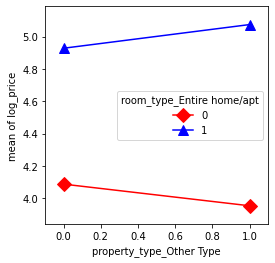

In [ ]:
cleaned_dum['entire*other']=cleaned_dum['property_type_Other Type']*cleaned_dum['room_type_Entire home/apt']
interactions_size= ['private_room*Hotel', 'entire*House', 'entire*other']
fig, ax = plt.subplots(figsize=(4, 4))
fig = interaction_plot(x=cleaned_dum['property_type_Other Type'], trace=cleaned_dum['room_type_Entire home/apt'], response=cleaned_dum['log_price'],
                       colors=['red', 'blue'], markers=['D', '^'], ms=10, ax=ax)
plt.show()

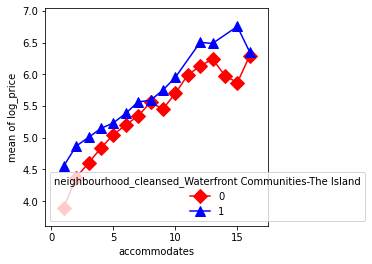

In [ ]:
fig, ax = plt.subplots(figsize=(4, 4))
fig = interaction_plot(x=cleaned_dum['accommodates'], trace=cleaned_dum['neighbourhood_cleansed_Waterfront Communities-The Island'], response=cleaned_dum['log_price'],
                       colors=['red', 'blue'], markers=['D', '^'], ms=10, ax=ax)
plt.show()

In [ ]:
cleaned.loc[(cleaned.neighbourhood_cleansed=='Waterfront Communities-The Island')&(cleaned.accommodates==14)]

,id,host_since,host_response_rate,host_is_superhost,host_listings_count,host_identity_verified,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,availability_365,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,bath_num,new_price,host_number_days,time_since_first_review,time_since_last_review,property_type_real,air_conditioning,bbq,balcony_or_patio,nature_and_views,bed_linen,breakfast,tv,coffee_machine,cooking_basics,major_appliances,elevator,gym,parking,outdoor_space,host_greeting,hot_tub_sauna_or_pool,internet,long_term_stays,private_entrance,Fire_Safety,essentials,computer_workspace,fireplace,review_scores_rating_num


In [ ]:
cleaned_dum['waterfront*accommodates']=cleaned_dum['neighbourhood_cleansed_Waterfront Communities-The Island']*cleaned_dum['accommodates']
cleaned_dum['annex*accommodates']=cleaned_dum['neighbourhood_cleansed_Annex']*cleaned_dum['accommodates']
cleaned_dum['bathhurst*accommodates']=cleaned_dum['neighbourhood_cleansed_Bathurst Manor']*cleaned_dum['accommodates']
cleaned_dum['baystreet*accommodates']=cleaned_dum['neighbourhood_cleansed_Bay Street Corridor']*cleaned_dum['accommodates']
cleaned_dum['yonge-church*accommodates']=cleaned_dum['neighbourhood_cleansed_Church-Yonge Corridor']*cleaned_dum['accommodates']
cleaned_dum['younge-stclair*accommodates']=cleaned_dum['neighbourhood_cleansed_Yonge-St.Clair']*cleaned_dum['accommodates']
cleaned_dum['uni*accommodates']=cleaned_dum['neighbourhood_cleansed_University']*cleaned_dum['accommodates']
cleaned_dum['beaches*accommodates']=cleaned_dum['neighbourhood_cleansed_The Beaches']*cleaned_dum['accommodates']
cleaned_dum['foresthill*accommodates']=cleaned_dum['neighbourhood_cleansed_Forest Hill South']*cleaned_dum['accommodates']
cleaned_dum['highpark*accommodates']=cleaned_dum['neighbourhood_cleansed_High Park-Swansea']*cleaned_dum['accommodates']
cleaned_dum['trinity*accommodates']=cleaned_dum['neighbourhood_cleansed_Trinity-Bellwoods']*cleaned_dum['accommodates']
cleaned_dum['scar*accommodates']=cleaned_dum['neighbourhood_cleansed_Centennial Scarborough']*cleaned_dum['accommodates']
cleaned_dum['niagara*accommodates']=cleaned_dum['neighbourhood_cleansed_Niagara']*cleaned_dum['accommodates']
cleaned_dum['rosedale*accommodates']=cleaned_dum['neighbourhood_cleansed_Rosedale-Moore Park']*cleaned_dum['accommodates']
cleaned_dum['cabbage*accommodates']=cleaned_dum['neighbourhood_cleansed_Cabbagetown-South St.James Town']*cleaned_dum['accommodates']
cleaned_dum['regent*accommodates']=cleaned_dum['neighbourhood_cleansed_Regent Park']*cleaned_dum['accommodates']
interactions_accommodates=['waterfront*accommodates', 'annex*accommodates', 'bathhurst*accommodates',
                           'baystreet*accommodates', 'yonge-church*accommodates', 'younge-stclair*accommodates','uni*accommodates', 
                           'beaches*accommodates', 'foresthill*accommodates',
                           'scar*accommodates', 'trinity*accommodates', 'highpark*accommodates','niagara*accommodates', 
                           'rosedale*accommodates', 'cabbage*accommodates', 'regent*accommodates']

##How do host characteristics affect listing price?

In [ ]:
host_resp =list(cleaned_dum.columns[cleaned_dum.columns.str.startswith('host_response_rate')])
host_super =list(cleaned_dum.columns[cleaned_dum.columns.str.startswith('host_is_superhost')])
host_verified =list(cleaned_dum.columns[cleaned_dum.columns.str.startswith('host_identity_verified')])
xvars_host=['host_greeting','host_number_days' ]+host_resp+host_super+host_verified

drop = ['host_identity_verified_t', 'host_response_rate_missing','host_is_superhost_t']
xvars_host = [e for e in xvars_host if e not in drop]
xvars_host


['host_greeting',
 'host_number_days',
 'host_response_rate_0-49%',
 'host_response_rate_100%',
 'host_response_rate_50-89%',
 'host_response_rate_90-99%',
 'host_is_superhost_f',
 'host_identity_verified_f']

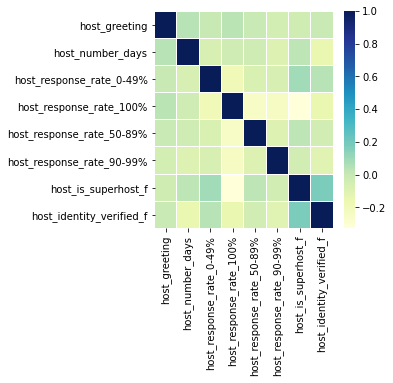

In [ ]:
host_df = cleaned_dum.filter(xvars_host, axis=1)
corrmat = host_df.corr()
f, ax = plt.subplots(figsize =(4, 4)) 
sns.heatmap(corrmat, annot=False, ax = ax, cmap ="YlGnBu", linewidths = 0.1)

plt.show()

In [ ]:
def host_plot(col, figsize=(8,3)):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    fig.suptitle(col, fontsize=16, y=1)
    #plt.subplots_adjust(top=0.80)
    
    cleaner_data.groupby(col).size().plot(kind='bar', ax=ax1, color=['blue', 'green'])
    ax1.set_xticklabels(labels=['No', 'Yes'], rotation=0)
    ax1.set_title('Count')
    ax1.set_xlabel('')
    
    cleaner_data.groupby(col).new_price.median().plot(kind='bar', ax=ax2, color=['blue', 'green'])
    ax2.set_xticklabels(labels=['No', 'Yes'], rotation=0)
    ax2.set_title('Median price')
    ax2.set_xlabel('')
    
    plt.show()
    print(cleaner_data.groupby(col).new_price.median())

***Binary Host Characteristics***

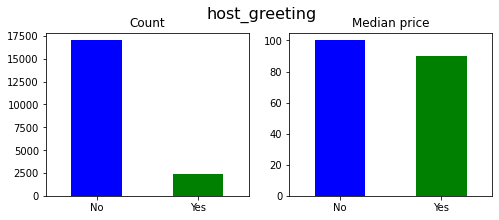

host_greeting
0.0    100.0
1.0     90.0
Name: new_price, dtype: float64


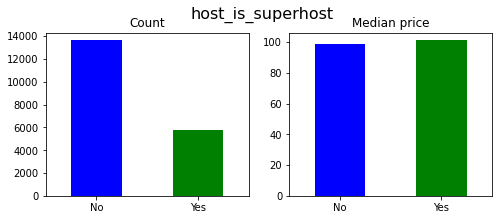

host_is_superhost
f     99.0
t    101.0
Name: new_price, dtype: float64


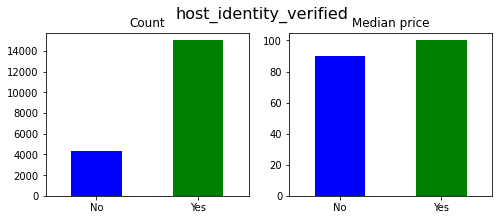

host_identity_verified
f     90.0
t    100.0
Name: new_price, dtype: float64


In [ ]:
host_binary_vars=['host_greeting','host_is_superhost','host_identity_verified']
for i in host_binary_vars:
  host_plot(i)

***Host Response Rate***

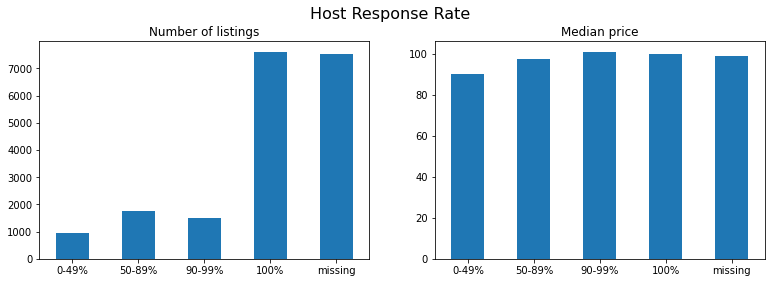

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13,4))
fig.suptitle('Host Response Rate', fontsize=16, y=1)
    
cleaned['host_response_rate'].value_counts().reindex(['0-49%', '50-89%', '90-99%', '100%', 'missing']).plot(kind='bar', ax=ax1)
ax1.tick_params(labelrotation=0)
ax1.set_title('Number of listings')
ax1.set_xlabel('')
    
cleaned.groupby('host_response_rate').new_price.median().reindex(['0-49%', '50-89%', '90-99%', '100%', 'missing']).plot(kind='bar', ax=ax2)
ax2.set_title('Median price')
ax2.set_xlabel('')
ax2.tick_params(labelrotation=0)
plt.show()

***Number of days as host***

In [ ]:
cleaner_data.host_number_days.describe()

count    19339.000000
mean      1626.215730
std        869.695169
min         22.000000
25%        914.000000
50%       1626.000000
75%       2215.000000
max       4435.000000
Name: host_number_days, dtype: float64

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


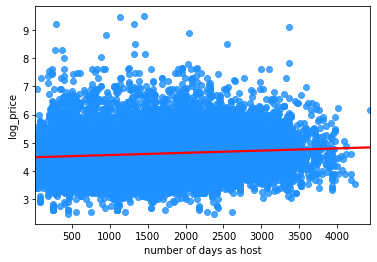

In [ ]:
ax = sns.regplot(cleaned_dum['host_number_days'], cleaned_dum['log_price'],scatter_kws={'color':'dodgerblue'},line_kws={'color':'r'})
ax.set_xlabel('number of days as host')
plt.show()

In [ ]:
res = sm.OLS(cleaned_dum['log_price'],sm.add_constant(cleaned_dum[xvars_host]),missing='drop').fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     35.79
Date:                Thu, 26 Nov 2020   Prob (F-statistic):           9.04e-57
Time:                        17:30:55   Log-Likelihood:                -20718.
No. Observations:               19334   AIC:                         4.145e+04
Df Residuals:                   19325   BIC:                         4.152e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         4.5593      0.017    260.606      0.000       4.525       4.594
host_greeting                -0.0989      0.016     -6.321      0.000      -0.130      -0.068
host_number_days           7.501e-05      6e-06     12.508      0.000    6.33e-05    8.68e-05
host_response_rate_0-49%     -0.0494      0.024     -2.030      0.042      -0.097      -0.002
host_response_rate_100%       0.0029      0.012      0.234      0.815      -0.021       0.027
host_response_rate_50-89%    -0.0813      0.019     -4.284      0.000      -0.118      -0.044
host_response_rate_90-99%    -0.0189      0.021     -0.915      0.360      -0.059       0.022
host_is_superhost_f          -0.0378      0.012     -3.151      0.002      -0.061      -0.014
host_identity_verified_f     -0.0592      0.013     -4.625      0.000      -0.084      -0.034
==============================================================================
Omnibus:                     1843.150   Durbin-Watson:                   1.870
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3716.008
Skew:                           0.628   Prob(JB):                         0.00
Kurtosis:                       4.743   Cond. No.                     1.02e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.02e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

##How do booking constraints affect listing price?

In [ ]:
xvars_constraint=['minimum_nights', 'instant_bookable_f']


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


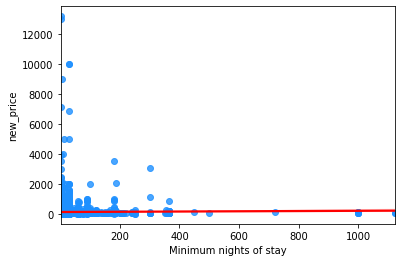

In [ ]:
ax = sns.regplot(cleaned_dum['minimum_nights'], cleaned_dum['new_price'],scatter_kws={'color':'dodgerblue'},line_kws={'color':'r'})
ax.set_xlabel('Minimum nights of stay')
plt.show()

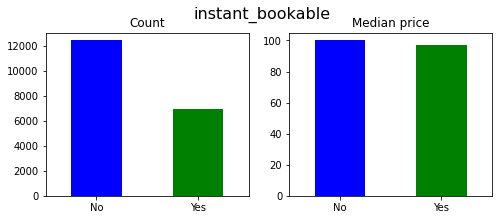

instant_bookable
f    100.0
t     97.0
Name: new_price, dtype: float64


In [ ]:
host_plot('instant_bookable')

##How do interior amenities affect listing price?

In [ ]:
xvars_amenities=['air_conditioning', 'balcony_or_patio', 'coffee_machine', 'bed_linen', 'tv', 'cooking_basics', 'major_appliances', 'elevator', 'gym', 
            'parking', 'outdoor_space', 'internet', 'private_entrance', 'Fire_Safety', 
            'hot_tub_sauna_or_pool', 'nature_and_views', 'breakfast', 'bbq', 'computer_workspace', 'fireplace']

In [ ]:
cleaned_dum[xvars_amenities].describe().T

,count,mean,std,min,25%,50%,75%,max
air_conditioning,19334.0,0.861591,0.345338,0.0,1.0,1.0,1.0,1.0
balcony_or_patio,19334.0,0.280180,0.449099,0.0,0.0,0.0,1.0,1.0
coffee_machine,19334.0,0.438812,0.496255,0.0,0.0,0.0,1.0,1.0
bed_linen,19334.0,0.410934,0.492016,0.0,0.0,0.0,1.0,1.0
tv,19334.0,0.710562,0.453513,0.0,0.0,1.0,1.0,1.0
cooking_basics,19334.0,0.949881,0.218196,0.0,1.0,1.0,1.0,1.0
major_appliances,19334.0,0.831954,0.373917,0.0,1.0,1.0,1.0,1.0
elevator,19334.0,0.353160,0.477964,0.0,0.0,0.0,1.0,1.0
gym,19334.0,0.280956,0.449478,0.0,0.0,0.0,1.0,1.0
parking,19334.0,0.673425,0.468972,0.0,0.0,1.0,1.0,1.0


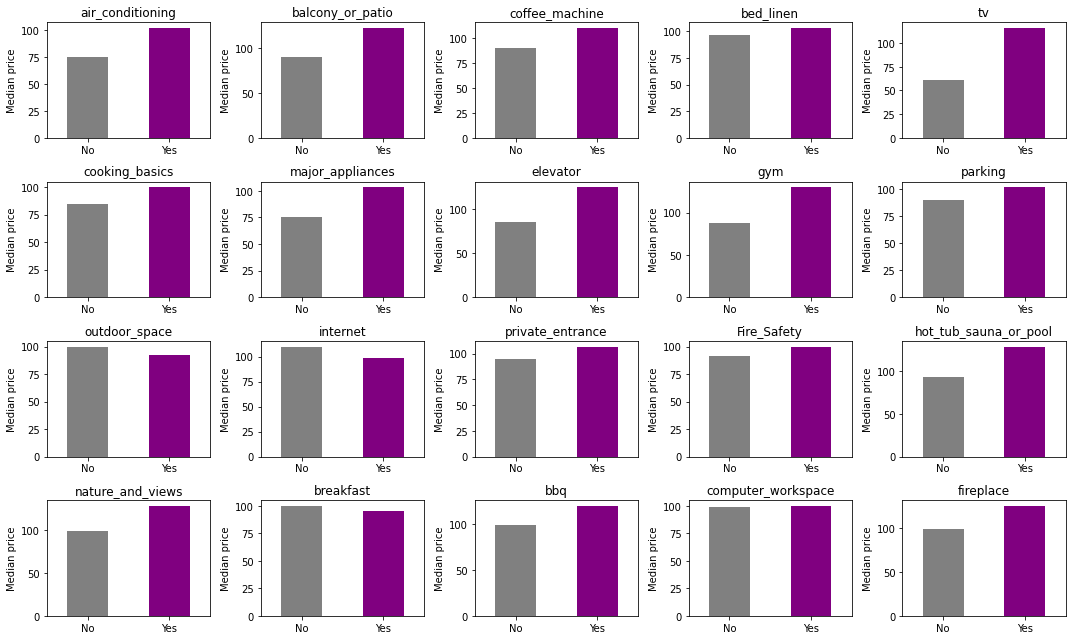

In [ ]:
#remove long-term stay and host_greeting
fig = plt.figure(figsize=(15,9))           # Define figure size

for i,var_name in enumerate(cleaner_data[xvars_amenities].columns):
    ax=plt.subplot(4,5,i+1)
    cleaner_data.groupby(var_name).new_price.median().plot(kind='bar', ax=ax, color=['grey', 'purple'])
    ax.set_xticklabels(labels=['No', 'Yes'], rotation=0)
    ax.set_ylabel('Median price')
    ax.set_xlabel('')
    ax.set_title(var_name)
plt.tight_layout()    
plt.show()

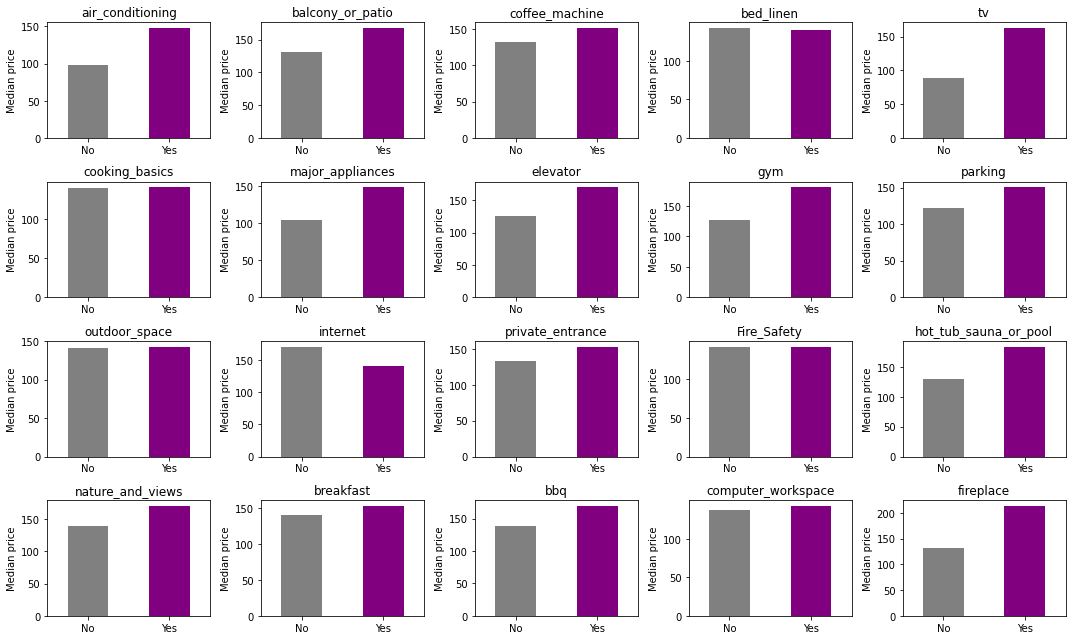

In [ ]:
fig = plt.figure(figsize=(15,9))           # Define figure size

for i,var_name in enumerate(cleaner_data[xvars_amenities].columns):
    ax=plt.subplot(4,5,i+1)
    cleaner_data.groupby(var_name).new_price.mean().plot(kind='bar', ax=ax, color=['grey', 'purple'])
    ax.set_xticklabels(labels=['No', 'Yes'], rotation=0)
    ax.set_ylabel('Median price')
    ax.set_xlabel('')
    ax.set_title(var_name)
plt.tight_layout()    
plt.show()

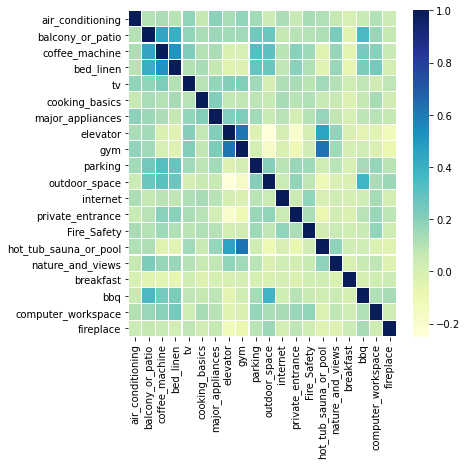

In [ ]:
amenities_df = cleaned_dum.filter(xvars_amenities, axis=1)
corrmat = amenities_df.corr()
f, ax = plt.subplots(figsize =(6, 6)) 
sns.heatmap(corrmat, annot=False, ax = ax, cmap ="YlGnBu", linewidths = 0.1)

plt.show()

In [ ]:
xvars_amenities.remove('elevator')
xvars_amenities.remove('coffee_machine')

In [ ]:
res = sm.OLS(cleaned_dum['log_price'],sm.add_constant(cleaned_dum[xvars_amenities]),missing='drop').fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.217
Model:                            OLS   Adj. R-squared:                  0.216
Method:                 Least Squares   F-statistic:                     297.3
Date:                Thu, 26 Nov 2020   Prob (F-statistic):               0.00
Time:                        17:31:02   Log-Likelihood:                -18495.
No. Observations:               19334   AIC:                         3.703e+04
Df Residuals:                   19315   BIC:                         3.718e+04
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     4.4945      0.037    120.293      0.000       4.421       4.568
air_conditioning          0.1247      0.014      8.991      0.000       0.098       0.152
balcony_or_patio          0.1383      0.012     11.366      0.000       0.114       0.162
bed_linen                -0.0433      0.011     -4.011      0.000      -0.064      -0.022
tv                        0.4629      0.011     43.135      0.000       0.442       0.484
cooking_basics           -0.1437      0.022     -6.613      0.000      -0.186      -0.101
major_appliances          0.1010      0.013      7.719      0.000       0.075       0.127
gym                       0.2397      0.014     17.703      0.000       0.213       0.266
parking                   0.0431      0.011      4.096      0.000       0.022       0.064
outdoor_space            -0.0638      0.014     -4.531      0.000      -0.091      -0.036
internet                 -0.3417      0.032    -10.642      0.000      -0.405      -0.279
private_entrance          0.1443      0.010     14.609      0.000       0.125       0.164
Fire_Safety              -0.0959      0.021     -4.472      0.000      -0.138      -0.054
hot_tub_sauna_or_pool     0.0177      0.015      1.203      0.229      -0.011       0.046
nature_and_views          0.0922      0.017      5.289      0.000       0.058       0.126
breakfast                -0.0508      0.017     -2.999      0.003      -0.084      -0.018
bbq                       0.0520      0.019      2.762      0.006       0.015       0.089
computer_workspace       -0.0462      0.011     -4.238      0.000      -0.068      -0.025
fireplace                 0.2507      0.015     16.618      0.000       0.221       0.280
==============================================================================
Omnibus:                     2837.307   Durbin-Watson:                   1.883
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7512.906
Skew:                           0.813   Prob(JB):                         0.00
Kurtosis:                       5.585   Cond. No.                         27.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

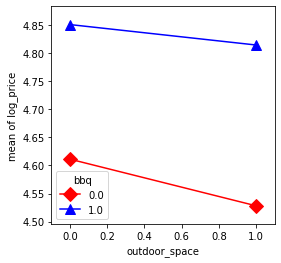

In [ ]:
fig, ax = plt.subplots(figsize=(4, 4))
fig = interaction_plot(x=cleaned_dum['outdoor_space'], trace=cleaned_dum['bbq'], response=cleaned_dum['log_price'],
                       colors=['red', 'blue'], markers=['D', '^'], ms=10, ax=ax)
plt.show()

In [ ]:
cleaned_dum['outdoor*baystreet']=cleaned_dum['outdoor_space']*cleaned_dum['neighbourhood_cleansed_Bay Street Corridor']
cleaned_dum['outdoor*bathurst']=cleaned_dum['outdoor_space']*cleaned_dum['neighbourhood_cleansed_Bathurst Manor']
cleaned_dum['outdoor*waterfront']=cleaned_dum['outdoor_space']*cleaned_dum['neighbourhood_cleansed_Waterfront Communities-The Island']
cleaned_dum['outdoor*apt']=cleaned_dum['outdoor_space']*cleaned_dum['property_type_Apartment']
cleaned_dum['outdoor*other']=cleaned_dum['outdoor_space']*cleaned_dum['property_type_Other Type']

interactions_out=['outdoor*waterfront', 'outdoor*baystreet','outdoor*bathurst', 'outdoor*other', 'outdoor*apt']

cleaned_dum['nature*yonge-church']=cleaned_dum['nature_and_views']*cleaned_dum['neighbourhood_cleansed_Church-Yonge Corridor']
interactions_nature = ['nature*yonge-church']
cleaned_dum['balcony_or_patio*church-yonge']=cleaned_dum['balcony_or_patio']*cleaned_dum['neighbourhood_cleansed_Church-Yonge Corridor']
interactions_balcony_or_patio=['balcony_or_patio*church-yonge']

In [ ]:
cleaned_dum['outdoor*bbq']=cleaned_dum['outdoor_space']*cleaned_dum['bbq']
cleaned_dum['outdoor*nature']=cleaned_dum['outdoor_space']*cleaned_dum['nature_and_views']
cleaned_dum['other*nature']=cleaned_dum['property_type_Other Type']*cleaned_dum['nature_and_views']
cleaned_dum['outdoor*hottub_pool']=cleaned_dum['outdoor_space']*cleaned_dum['hot_tub_sauna_or_pool']
cleaned_dum['breakfast*cooking']=cleaned_dum['breakfast']*cleaned_dum['cooking_basics']
cleaned_dum['breakfast*hotel']=cleaned_dum['breakfast']*cleaned_dum['property_type_Hotel']
cleaned_dum['house*gym']=cleaned_dum['property_type_House']*cleaned_dum['gym']
cleaned_dum['house*entrance']=cleaned_dum['property_type_House']*cleaned_dum['private_entrance']
cleaned_dum['other*entrance']=cleaned_dum['property_type_Other Type']*cleaned_dum['private_entrance']
interactions_amenities=['outdoor*bbq','outdoor*nature','other*nature', 'house*gym', 'breakfast*hotel',
                        'outdoor*hottub_pool', 'breakfast*cooking', 'house*entrance', 'other*entrance']



###Pricing Model with All Features

In [ ]:
res = sm.OLS(cleaned_dum['log_price'],sm.add_constant(cleaned_dum[xvars_size+xvars_prop_type+neighbourhoods+xvars_host+xvars_amenities+xvars_review]),missing='drop').fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.584
Model:                            OLS   Adj. R-squared:                  0.580
Method:                 Least Squares   F-statistic:                     150.9
Date:                Thu, 26 Nov 2020   Prob (F-statistic):               0.00
Time:                        17:31:03   Log-Likelihood:                -12388.
No. Observations:               19334   AIC:                         2.513e+04
Df Residuals:                   19155   BIC:                         2.654e+04
Df Model:                         178                                         
Covariance Type:            nonrobust                                         
==============================================================================================================================
                                                                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------
const                                                          3.4814      0.099     35.113      0.000       3.287       3.676
accommodates                                                   0.1360      0.002     68.540      0.000       0.132       0.140
room_type_Entire home/apt                                      0.8709      0.028     31.645      0.000       0.817       0.925
room_type_Private room                                         0.4401      0.027     16.416      0.000       0.388       0.493
property_type_Hotel                                            0.6028      0.039     15.570      0.000       0.527       0.679
property_type_House                                            0.0566      0.009      5.996      0.000       0.038       0.075
property_type_Other Type                                       0.0722      0.049      1.472      0.141      -0.024       0.168
neighbourhood_cleansed_Agincourt North                        -0.0864      0.118     -0.734      0.463      -0.317       0.144
neighbourhood_cleansed_Agincourt South-Malvern West           -0.0251      0.104     -0.242      0.809      -0.228       0.178
neighbourhood_cleansed_Annex                                   0.3253      0.093      3.513      0.000       0.144       0.507
neighbourhood_cleansed_Banbury-Don Mills                       0.0981      0.110      0.888      0.375      -0.118       0.315
neighbourhood_cleansed_Bathurst Manor                          0.1846      0.116      1.586      0.113      -0.044       0.413
neighbourhood_cleansed_Bay Street Corridor                     0.4041      0.093      4.343      0.000       0.222       0.586
neighbourhood_cleansed_Bayview Village                         0.1095      0.101      1.083      0.279      -0.089       0.308
neighbourhood_cleansed_Bayview Woods-Steeles                   0.1408      0.107      1.311      0.190      -0.070       0.351
neighbourhood_cleansed_Bedford Park-Nortown                    0.0232      0.108      0.215      0.830      -0.188       0.235
neighbourhood_cleansed_Beechborough-Greenbrook                 0.1401      0.166      0.842      0.400      -0.186       0.466
neighbourhood_cleansed_Bendale                                -0.0923      0.108     -0.851      0.395      -0.305       0.120
neighbourhood_cleansed_Birchcliffe-Cliffside                  -0.0656      0.102     -0.644      0.520      -0.265       0.134
neighbourhood_cleansed_Black Creek                            -0.1434      0.138     -1.043      0.297      -0.413       0.126
neighbourhood_cleansed_Blake-Jones                             0.0403      0.107      0.378      0.706      -0.169       0.250
neighbourhood_cleansed_Briar Hill-B

***Model including interaction terms***

In [ ]:
res = sm.OLS(cleaned_dum['log_price'],sm.add_constant(cleaned_dum[xvars_size+xvars_prop_type+neighbourhoods+xvars_host+xvars_constraint+xvars_amenities+interactions_house+interactions_size+interactions_accommodates+interactions_out+interactions_nature+interactions_balcony_or_patio+interactions_amenities+xvars_review]),missing='drop').fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.590
Model:                            OLS   Adj. R-squared:                  0.585
Method:                 Least Squares   F-statistic:                     124.5
Date:                Thu, 26 Nov 2020   Prob (F-statistic):               0.00
Time:                        17:31:04   Log-Likelihood:                -12240.
No. Observations:               19334   AIC:                         2.492e+04
Df Residuals:                   19112   BIC:                         2.667e+04
Df Model:                         221                                         
Covariance Type:            nonrobust                                         
==============================================================================================================================
                                                                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------
const                                                          3.5108      0.099     35.510      0.000       3.317       3.705
accommodates                                                   0.1349      0.002     54.542      0.000       0.130       0.140
room_type_Entire home/apt                                      0.8294      0.028     29.706      0.000       0.775       0.884
room_type_Private room                                         0.4554      0.027     16.987      0.000       0.403       0.508
property_type_Hotel                                            0.3517      0.165      2.136      0.033       0.029       0.674
property_type_House                                           -0.0204      0.014     -1.447      0.148      -0.048       0.007
property_type_Other Type                                      -0.0583      0.060     -0.978      0.328      -0.175       0.059
neighbourhood_cleansed_Agincourt North                        -0.0630      0.117     -0.538      0.590      -0.292       0.166
neighbourhood_cleansed_Agincourt South-Malvern West           -0.0065      0.103     -0.063      0.950      -0.209       0.196
neighbourhood_cleansed_Annex                                   0.2648      0.099      2.688      0.007       0.072       0.458
neighbourhood_cleansed_Banbury-Don Mills                       0.1055      0.110      0.960      0.337      -0.110       0.321
neighbourhood_cleansed_Bathurst Manor                          0.0404      0.176      0.229      0.819      -0.305       0.386
neighbourhood_cleansed_Bay Street Corridor                     0.4965      0.099      5.034      0.000       0.303       0.690
neighbourhood_cleansed_Bayview Village                         0.1250      0.101      1.243      0.214      -0.072       0.322
neighbourhood_cleansed_Bayview Woods-Steeles                   0.1678      0.107      1.571      0.116      -0.042       0.377
neighbourhood_cleansed_Bedford Park-Nortown                    0.0436      0.107      0.406      0.685      -0.167       0.254
neighbourhood_cleansed_Beechborough-Greenbrook                 0.1717      0.165      1.039      0.299      -0.152       0.496
neighbourhood_cleansed_Bendale                                -0.0864      0.108     -0.802      0.423      -0.298       0.125
neighbourhood_cleansed_Birchcliffe-Cliffside                  -0.0658      0.101     -0.649      0.516      -0.264       0.133
neighbourhood_cleansed_Black Creek                            -0.1467      0.137     -1.074      0.283      -0.415       0.121
neighbourhood_cleansed_Blake-Jones                             0.0430      0.106      0.406      0.685      -0.165       0.251
neighbourhood_cleansed_Briar Hill-B

###Investigating Model Results

In [ ]:
waterfront_x_8 =cleaned.loc[(cleaned.neighbourhood_cleansed=='Waterfront Communities-The Island')&(cleaned.accommodates > 8)]

Computer_workspace


In [ ]:
mask = cleaned["computer_workspace"] == 0
no_comp_workspace = cleaned.loc[:,['property_type_real','new_price']][mask]
no_comp_workspace = no_comp_workspace.sort_values(by=['new_price'],ascending = False)
prop_type_unique = no_comp_workspace['property_type_real'][0:100].unique()
no_comp_dict = {}
for i in enumerate(prop_type_unique):
  mask = no_comp_workspace['property_type_real'] == i[1]
  count = len(no_comp_workspace['property_type_real'][0:100][mask])
  no_comp_dict[i[1]] = count
no_comp_dict

{'Boat': 1,
 'Entire apartment': 15,
 'Entire bungalow': 3,
 'Entire condominium': 18,
 'Entire house': 29,
 'Entire loft': 6,
 'Entire place': 1,
 'Entire townhouse': 3,
 'Entire villa': 3,
 'Private room in apartment': 7,
 'Private room in house': 9,
 'Private room in townhouse': 1,
 'Shared room in apartment': 3,
 'Shared room in condominium': 1}

In [ ]:
mask = no_comp_workspace['property_type_real'] == 'Boat'
no_comp_workspace[mask]

,property_type_real,new_price
8237,Boat,900.0


In [ ]:
no_comp_workspace[0:50]

,property_type_real,new_price
3831,Entire villa,5000.00
15118,Entire bungalow,3958.00
2263,Shared room in apartment,2429.00
1596,Entire house,2142.00
3582,Entire condominium,2000.00
1610,Entire loft,2000.00
1204,Entire villa,1999.00
12124,Entire condominium,1794.00
11588,Entire apartment,1793.71
15082,Entire house,1750.00


Nature_and_views

In [ ]:
mask = cleaned["nature_and_views"] == 0
no_nature_and_views = cleaned.loc[:,['property_type_real','new_price']][mask]
no_nature_and_views = no_nature_and_views.sort_values(by=['new_price'],ascending = False)
prop_type_unique = no_nature_and_views['property_type_real'][0:100].unique()
no_nature_and_views_dict = {}
for i in enumerate(prop_type_unique):
  mask = no_nature_and_views['property_type_real'] == i[1]
  count = len(no_nature_and_views['property_type_real'][0:100][mask])
  no_nature_and_views_dict[i[1]] = count
no_nature_and_views_dict

{'Entire apartment': 17,
 'Entire bungalow': 3,
 'Entire condominium': 21,
 'Entire guest suite': 1,
 'Entire house': 29,
 'Entire loft': 5,
 'Entire place': 1,
 'Entire serviced apartment': 2,
 'Entire townhouse': 9,
 'Entire villa': 5,
 'Private room in apartment': 4,
 'Private room in house': 2,
 'Shared room in apartment': 1}

In [ ]:
no_nature_and_views[0:50]

,property_type_real,new_price
4761,Entire condominium,13164.00
6659,Entire condominium,13000.00
13723,Entire condominium,10000.00
16289,Entire condominium,9999.00
9714,Entire condominium,9000.00
15918,Entire apartment,7155.00
8110,Entire loft,6848.00
3831,Entire villa,5000.00
14562,Entire townhouse,5000.00
19172,Entire condominium,4004.00


Fire_Safety

In [ ]:
mask = cleaned["Fire_Safety"] == 0
no_fire_safety = cleaned.loc[:,['property_type_real','new_price']][mask]
no_fire_safety = no_fire_safety.sort_values(by=['new_price'],ascending = False)
prop_type_unique = no_fire_safety['property_type_real'][0:100].unique()
no_fire_safety_dict = {}
for i in enumerate(prop_type_unique):
  mask = no_fire_safety['property_type_real'] == i[1]
  count = len(no_fire_safety['property_type_real'][0:100][mask])
  no_fire_safety_dict[i[1]] = count
no_fire_safety_dict

{'Boat': 1,
 'Camper/RV': 1,
 'Entire apartment': 29,
 'Entire condominium': 15,
 'Entire house': 24,
 'Entire loft': 2,
 'Entire place': 1,
 'Entire townhouse': 2,
 'Private room in apartment': 4,
 'Private room in condominium': 4,
 'Private room in guest suite': 1,
 'Private room in house': 12,
 'Shared room in apartment': 2,
 'Shared room in condominium': 1,
 'Shared room in house': 1}

In [ ]:
mask = no_fire_safety['property_type_real'] == 'Boat'
no_fire_safety[mask]

,property_type_real,new_price
8237,Boat,900.0
13206,Boat,130.0


In [ ]:
mask = no_fire_safety['property_type_real'] == 'Camper/RV'
no_fire_safety[mask]

,property_type_real,new_price
10363,Camper/RV,400.0
9413,Camper/RV,188.0


Private_entrance

In [ ]:
mask = cleaned["private_entrance"] == 0
no_private_entrance = cleaned.loc[:,['property_type_real','new_price']][mask]
no_private_entrance = no_private_entrance.sort_values(by=['new_price'],ascending = False)
prop_type_unique = no_private_entrance['property_type_real'][0:100].unique()
no_private_entrance_dict = {}
for i in enumerate(prop_type_unique):
  mask = no_private_entrance['property_type_real'] == i[1]
  count = len(no_private_entrance['property_type_real'][0:100][mask])
  no_private_entrance_dict[i[1]] = count
no_private_entrance_dict

{'Boat': 1,
 'Entire apartment': 20,
 'Entire bungalow': 1,
 'Entire condominium': 25,
 'Entire house': 23,
 'Entire loft': 5,
 'Entire place': 1,
 'Entire serviced apartment': 1,
 'Entire townhouse': 4,
 'Entire villa': 4,
 'Private room in apartment': 6,
 'Private room in condominium': 2,
 'Private room in house': 5,
 'Shared room in apartment': 1,
 'Shared room in condominium': 1}

In [ ]:
mask1 = cleaned["private_entrance"] == 0
mask2 = cleaned['property_type_real'].str.contains('room')
room_no_private_entrance = cleaned[mask1][mask2].sort_values(by=['new_price'],ascending = False)
room_no_private_entrance[0:50]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


,id,host_since,host_response_rate,host_is_superhost,host_listings_count,host_identity_verified,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,availability_365,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,bath_num,new_price,host_number_days,time_since_first_review,time_since_last_review,property_type_real,air_conditioning,bbq,balcony_or_patio,nature_and_views,bed_linen,breakfast,tv,coffee_machine,cooking_basics,major_appliances,elevator,gym,parking,outdoor_space,host_greeting,hot_tub_sauna_or_pool,internet,long_term_stays,private_entrance,Fire_Safety,essentials,computer_workspace,fireplace,review_scores_rating_num
2263,8173162,2015-03-07,0-49%,f,1.0,f,Bay Street Corridor,43.66908,-79.38774,Apartment,Shared room,1,1.0,NaN,[],"$2,429.00",1,1125,365,0,NaT,NaT,nan,nan,nan,nan,nan,nan,nan,f,NaN,2429.0,2033.0,nan,nan,Shared room in apartment,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
12715,34540503,2019-05-08,missing,f,1.0,f,Church-Yonge Corridor,43.66174,-79.37739,Apartment,Private room,1,1.0,1.0,"[""Carbon monoxide alarm"", ""Dryer"", ""Elevator"",...","$1,339.00",30,122,90,0,NaT,NaT,nan,nan,nan,nan,nan,nan,nan,t,1.0,1339.0,510.0,nan,nan,Private room in apartment,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,NaN
17305,42566961,2015-11-26,missing,f,0.0,t,St.Andrew-Windfields,43.76171,-79.37849,House,Private room,13,7.0,NaN,"[""TV"", ""Dryer"", ""Free parking on premises"", ""K...","$1,320.00",2,1125,90,0,NaT,NaT,nan,nan,nan,nan,nan,nan,nan,t,6.0,1320.0,1769.0,nan,nan,Private room in house,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,NaN
1612,6583985,2015-05-28,missing,f,2.0,f,Waterfront Communities-The Island,43.65042,-79.38758,Apartment,Private room,1,1.0,1.0,"[""TV"", ""Dryer"", ""Elevator"", ""Gym"", ""Kitchen"", ...","$1,200.00",1,1125,0,0,NaT,NaT,nan,nan,nan,nan,nan,nan,nan,f,1.0,1200.0,1951.0,nan,nan,Private room in apartment,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,NaN
16519,41208950,2020-01-01,0-49%,f,0.0,t,Bedford Park-Nortown,43.71325,-79.42791,Apartment,Private room,1,1.0,NaN,"[""Shampoo"", ""Dryer"", ""Lock on bedroom door"", ""...","$1,000.00",3,1125,89,1,2020-02-25,2020-02-25,95-100/100,10/10,10/10,10/10,10/10,10/10,10/10,t,1.5,1000.0,272.0,0.5-1 year,6-12 months,Private room in apartment,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,100.0
1481,6262182,2015-05-03,100%,f,1.0,t,Morningside,43.77123,-79.20768,House,Private room,4,2.0,3.0,"[""Carbon monoxide alarm"", ""Breakfast"", ""Air co...","$1,000.00",2,14,180,75,2015-09-07,2020-03-08,95-100/100,10/10,10/10,10/10,10/10,9/10,10/10,t,1.5,1000.0,1976.0,4+ years,6-12 months,Private room in house,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,97.0
9349,26780473,2018-07-10,missing,f,1.0,t,Danforth,43.68600,-79.31610,House,Private room,1,1.0,1.0,"[""Wifi""]",$999.00,1,2,363,1,2018-07-14,2018-07-14,95-100/100,10/10,10/10,10/10,10/10,10/10,10/10,f,1.0,999.0,812.0,2-3 years,12+ months,Private room in house,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0
9065,26100911,2018-06-17,missing,f,1.0,t,Waterfront Communities-The Island,43.64009,-79.39742,Apartment,Shared room,2,1.0,1.0,"[""Essentials""]",$999.00,1,1125,179,1,2018-07-15,2018-07-15,95-100/100,10/10,10/10,10/10,10/10,10/10,10/10,f,1.0,999.0,835.0,2-3 years,12+ months,Shared room in condominium,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,100.0
5375,17859904,2017-03-23,missing,f,1.

Internet

In [ ]:
mask = cleaned["internet"] == 0
no_internet = cleaned.loc[:,['property_type_real','new_price']][mask]
no_internet = no_internet.sort_values(by=['new_price'],ascending = False)
prop_type_unique = no_internet['property_type_real'][0:100].unique()
no_internet_dict = {}
for i in enumerate(prop_type_unique):
  mask = no_internet['property_type_real'] == i[1]
  count = len(no_internet['property_type_real'][0:100][mask])
  no_internet_dict[i[1]] = count
no_internet_dict

{'Boat': 2,
 'Camper/RV': 2,
 'Entire apartment': 19,
 'Entire bungalow': 1,
 'Entire condominium': 31,
 'Entire guest suite': 1,
 'Entire house': 15,
 'Entire loft': 2,
 'Entire townhouse': 4,
 'Private room': 1,
 'Private room in apartment': 3,
 'Private room in bungalow': 1,
 'Private room in condominium': 3,
 'Private room in guest suite': 1,
 'Private room in house': 9,
 'Private room in townhouse': 1,
 'Shared room in apartment': 1,
 'Shared room in condominium': 2,
 'Tiny house': 1}

In [ ]:
mask = no_internet['property_type_real'] == 'Tiny house'
no_internet[mask]

,property_type_real,new_price
15060,Tiny house,186.0


In [ ]:
mask = no_internet['property_type_real'] == 'Camper/RV'
no_internet[mask]

,property_type_real,new_price
10363,Camper/RV,400.0
9413,Camper/RV,188.0
18987,Camper/RV,123.0


In [ ]:
no_internet[0:20]

,property_type_real,new_price
4520,Entire condominium,3500.0
2263,Shared room in apartment,2429.0
1142,Entire apartment,1450.0
1520,Entire house,1300.0
14875,Entire apartment,1075.0
15351,Entire guest suite,1000.0
9065,Shared room in condominium,999.0
8237,Boat,900.0
5221,Private room in house,900.0
1584,Entire apartment,900.0


cooking_basics

In [ ]:
mask = cleaned["cooking_basics"] == 0
no_cooking_basics = cleaned.loc[:,['property_type_real','new_price']][mask]
no_cooking_basics = no_cooking_basics.sort_values(by=['new_price'],ascending = False)
prop_type_unique = no_cooking_basics['property_type_real'][0:100].unique()
no_cooking_basics_dict = {}
for i in enumerate(prop_type_unique):
  mask = no_cooking_basics['property_type_real'] == i[1]
  count = len(no_cooking_basics['property_type_real'][0:100][mask])
  no_cooking_basics_dict[i[1]] = count
no_cooking_basics_dict

{'Entire apartment': 15,
 'Entire condominium': 15,
 'Entire house': 19,
 'Entire loft': 2,
 'Entire place': 1,
 'Entire villa': 2,
 'Private room in apartment': 6,
 'Private room in condominium': 2,
 'Private room in guest suite': 1,
 'Private room in house': 12,
 'Private room in townhouse': 1,
 'Room in boutique hotel': 21,
 'Room in hotel': 1,
 'Shared room in apartment': 1,
 'Shared room in condominium': 1}

Bed_linen

In [ ]:
mask = cleaned["bed_linen"] == 0
no_bed_linen = cleaned.loc[:,['property_type_real','new_price']][mask]
no_bed_linen = no_bed_linen.sort_values(by=['new_price'],ascending = False)
prop_type_unique = no_bed_linen['property_type_real'][0:100].unique()
no_bed_linen_dict = {}
for i in enumerate(prop_type_unique):
  mask = no_bed_linen['property_type_real'] == i[1]
  count = len(no_bed_linen['property_type_real'][0:100][mask])
  no_bed_linen_dict[i[1]] = count
no_bed_linen_dict

{'Boat': 1,
 'Entire apartment': 13,
 'Entire bungalow': 2,
 'Entire condominium': 26,
 'Entire guest suite': 1,
 'Entire house': 30,
 'Entire loft': 5,
 'Entire place': 1,
 'Entire serviced apartment': 1,
 'Entire townhouse': 5,
 'Entire villa': 3,
 'Private room in apartment': 6,
 'Private room in house': 4,
 'Shared room in apartment': 1,
 'Shared room in condominium': 1}